# AFM SINDy and AIC analysis for all clusters assuming in contact constraints

### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from pysindy.utils import lorenz, lorenz_control, enzyme
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import pysindy as ps
import cvxpy
import math
import pandas as pd

# Define the directory path where the notebook is located
directory_path = "/Users/santiago/Documents/PhD_documents/Python_Simulations/Learning_SINDy/Github_Repository/"

# Run the target notebook using the %run magic command
# Note: This only works inside Jupyter Notebook or IPython
%run $directory_path/AFM_SINDy_algorithm_functions.ipynb

# Equation of motion of a cantilever beam using a DMT Model

Here, the idea is to be able to simulate the cantilever with a DMT model. The non-smooth equations are of the form:

\begin{equation}
\text{Attractive Eq.} \begin{cases}\ddot{\tilde{q_1}}+D_1^{\text{att}}\dot{\tilde{q_1}}+K_1\dot{\tilde{q_1}} = -C_1-F_{ts,1}(\bar{z})+B_1 \bar{\Omega}^2\bar{y}\sin{\bar{\Omega}\tau} \\ \ddot{\tilde{q_2}}+D_2^{\text{att}}\dot{\tilde{q_2}}+K_2\dot{\tilde{q_2}} = -C_2-F_{ts,2}(\bar{z})+B_2 \bar{\Omega}^2\bar{y}\sin{\bar{\Omega}\tau}\end{cases}
\end{equation}

\begin{equation}
\text{Repulsive Eq.} \begin{cases}\ddot{\tilde{q_1}}+D_1^{\text{rep}}\dot{\tilde{q_1}}+K_1\dot{\tilde{q_1}} = -C_1-F_{ts,1}(\bar{z})+B_1 \bar{\Omega}^2\bar{y}\sin{\bar{\Omega}\tau} \\ \ddot{\tilde{q_2}}+D_2^{\text{rep}}\dot{\tilde{q_2}}+K_2\dot{\tilde{q_2}} = -C_2-F_{ts,2}(\bar{z})+B_2 \bar{\Omega}^2\bar{y}\sin{\bar{\Omega}\tau}\end{cases}
\end{equation}

# Equation of motion of a cantilever beam using a DMT + Viscoelastic damping

Here, the idea is to be able to simulate the cantilever with a DMT model with Viscoelastic damping. The equations would be simulated in their phase space form as follows:

\begin{equation}
\text{Attractive Eq.} \begin{cases}\dot{\eta_1}=\eta_2 \\ \dot{\eta_2}= -d_1\eta_2-\eta_1-C_1-\dfrac{C_1}{{(1-\eta_1)}^{2}}+B_1\bar{\Omega}^{2} \bar{y}\sin{\phi}\\ \dot{\phi}=1\end{cases}
\end{equation}

\begin{equation}
\text{Repulsive Eq.} \begin{cases}\dot{\eta_1}=\eta_2 \\ \dot{\eta_2}=-d_2 \eta_2 -\eta_1 -C_1-C_2(a_0-[1-\eta_1])^{1.5}-C_3(\sqrt{a_0-[1-\eta_1]}\cdot \eta_2)-\dfrac{C_4}{a_0^2}+\bar{y}\bar{\Omega}^{2}B_1\sin{\phi} \\ \dot{\phi}=1 \end{cases}
\end{equation}

In [2]:
def AFM_w_DMT_viscoelastic_damp(t, y, a0, d1, d2, C1, C2, C3, B1, y_bar, forcing_freq):
    
    eta_1, eta_2, phase = y

    deta1dt = eta_2

    if 1-eta_1 <= a0: 
        deta2dt = (-d2*eta_2) - eta_1 - C1 - (C1/a0**2) - C2* (a0-(1 - eta_1))**1.5 - C3*(((a0-(1 - eta_1))**(0.5))*eta_2) + y_bar * (forcing_freq) ** 2 * B1 * np.sin(phase) #Repulsive regime
    else: 
        deta2dt = (-d1*eta_2) - eta_1 - C1 - (C1/(1-eta_1)**2) + y_bar * (forcing_freq) ** 2 * B1 * np.sin(phase)  #Attractive regime

    dphase_dt = forcing_freq

    return [deta1dt, deta2dt,dphase_dt] 

In [3]:
C1 = -1.27462*10**(-6)
C2 =  4.63118
C3 = -4e-1 
B1 = 1.56598
a0 = 0.0132626 
d1 = 0.0034 / 2
d2 = 4.057 / 2
forcing_freq = 1.002 
y_bar = 0.05585 
F_act = B1*(forcing_freq**2)*y_bar 

dt = 0.01 
t_train_DMT = np.arange(0, 1000, dt) #time until 1000 steps
init_cond_DMT = [0.0, 0.0, 0.0] # Initial conditions for position and velocity respectibly
t_train_span_DMT = (t_train_DMT[0], t_train_DMT[-1])  # Time span for the simulation

#Solve initial value problem
AFM_DMT_ivp = solve_ivp(AFM_w_DMT_viscoelastic_damp, t_train_span_DMT, init_cond_DMT, t_eval=t_train_DMT, args=(a0, d1, d2, C1, C2, C3, B1, y_bar, forcing_freq), rtol=1e-6, atol=1e-8, method = 'RK45', dense_output=True)  #`atol`. Default values are 1e-3 for `rtol` and 1e-6 for `atol`.
x_train_DMT = AFM_DMT_ivp.y.T
t_train_DMT_ivp = AFM_DMT_ivp.t

#### Cantilever beam data:

Define the parameters for the cantilever to be simualted

In [4]:
eta_star = 8.88249 #in [nm] for a system: Si-Si Region II (Rützel, S. & Raman, A., 2002)
w_0_cant = 2*np.pi*11.086e3 #first natural frequency of cantilever in [rad/s]
Q_factor = 100 #In air for a system: Si-Si Region II (Rützel, S. & Raman, A., 2002)

### Generate multiple trajectories for validation

In [5]:
x_train_DMT_mult_traj, init_cond_list = generate_different_trajectories(dynamical_system= AFM_w_DMT_viscoelastic_damp, t_train = t_train_DMT, DOF = 3,
                                                       num_trajectories = 3, noisy_trajectories = False, parameters = (a0,d1,d2,C1,C2,C3, B1,y_bar,forcing_freq), 
                                                       noise_level = None, init_cond_range = [(-0.5, 0.5), (-0.25, 0.25), (0,2*np.pi)])

Generating Trajectories: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


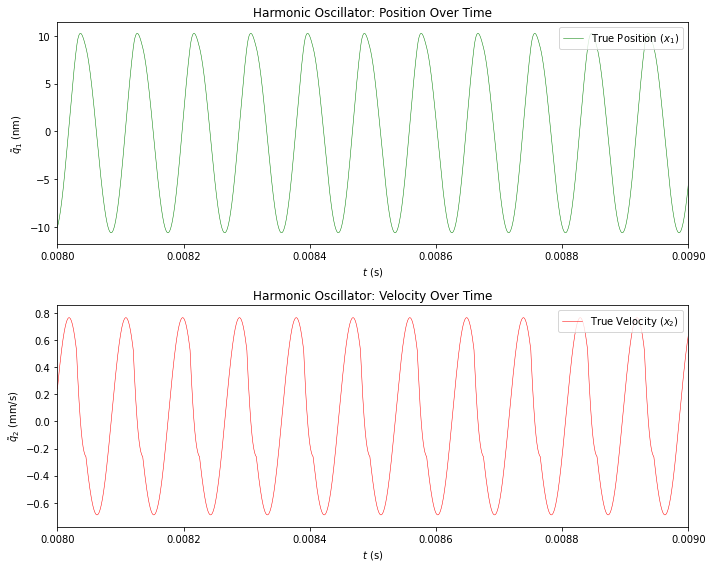

In [6]:
# Select the signal to plot:
signal = x_train_DMT_mult_traj[1] #one of the multiple generated trajectories
time = t_train_DMT

#Calculations to set the units back on the equation results
x_train_true_disp, true_t_train_DMT = get_true_AFM_displacement(signal[:,0], eta_star, tau_array=time, omega_0=w_0_cant)
x_train_true_vel, true_t_train_DMT = get_true_AFM_velocity(signal[:,1], eta_star, tau_array=time, omega_0=w_0_cant)
x_train_true_vel = x_train_true_vel*(1e-9)*(1000) #for velcolity in [mm/s]

# Setup the figure and subplots
set_plot_style()
fig, axs = plt.subplots(2, 1, figsize=(10, 8))  # 2 Rows, 1 Column

# First subplot for Position
axs[0].plot(true_t_train_DMT, x_train_true_disp, linewidth=0.5, label='True Position ($x_1$)', color = 'g')
axs[0].set_xlabel(r'$t$ (s)')
axs[0].set_ylabel(r'$\tilde{q}_1$ (nm)')
axs[0].legend(loc = 'upper right')
axs[0].set_title('Harmonic Oscillator: Position Over Time')
axs[0].set_xlim([0.008, 0.009])

# Second subplot for Velocity
axs[1].plot(true_t_train_DMT, x_train_true_vel, linewidth=0.5, label='True Velocity ($x_2$)', color = 'r')
axs[1].set_xlabel(r'$t$ (s)')
axs[1].set_ylabel(r'$\tilde{q}_2$ (mm/s)')
axs[1].legend(loc = 'upper right')
axs[1].set_title('Harmonic Oscillator: Velocity Over Time')
axs[1].set_xlim([0.008, 0.009])
plt.tight_layout() 
file_name = 'simple_oscillator_2_1st try'
# plt.savefig(f't_{file_name}.jpg', dpi=300, bbox_inches='tight') #to save the image if needed

## Creation of trajectory Clusters

### Placing Cluster Centers

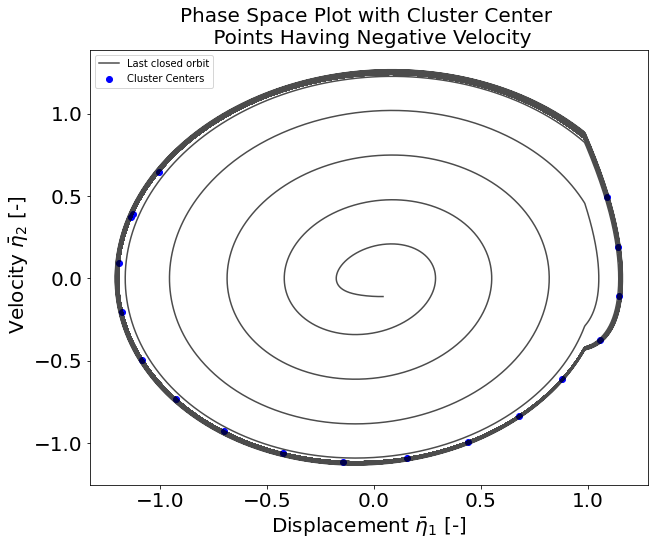

18


In [7]:
mult_traj_cluster_centers_x, mult_traj_cluster_centers_y = define_cluster_centers(x_train_mult_trajectories = x_train_DMT_mult_traj, num_points_high_res=800, 
                                                              sub_sample_val=30, filter_vel_max_val = 0.7, index_to_plot = 0, centers_loc = 3,
                                                              plot_file_name = None, plot=True, save_plot=False, multiple_init_cond =True)

print(len(mult_traj_cluster_centers_x[0]))

## Filter extra points from clustering

In [8]:
# Flatten the lists and combine each corresponding x and y into a single list of tuples
combined_x = np.hstack(mult_traj_cluster_centers_x)
combined_y = np.hstack(mult_traj_cluster_centers_y)

# Filter points
filtered_x, filtered_y = filter_close_points(combined_x, combined_y)

### Generating cluster from cluster centers

In [9]:
mult_traj_clusters_sections, mult_traj_clusters_dots_list = generate_fixed_clusters_from_centers(cluster_size= 18, x_train_mult_trajectories = x_train_DMT_mult_traj[0],
                                                                                                 KNN_neighbors_num = 400, KNN_radius = 1, 
                                                                                                 mult_traj_cluster_centers_x = filtered_x, #mult_traj_cluster_centers_x[0], #[0:8]
                                                                                                 mult_traj_cluster_centers_y = filtered_y, #mult_traj_cluster_centers_y[0], #[0:8] 
                                                                                                 multiple_init_cond = False)

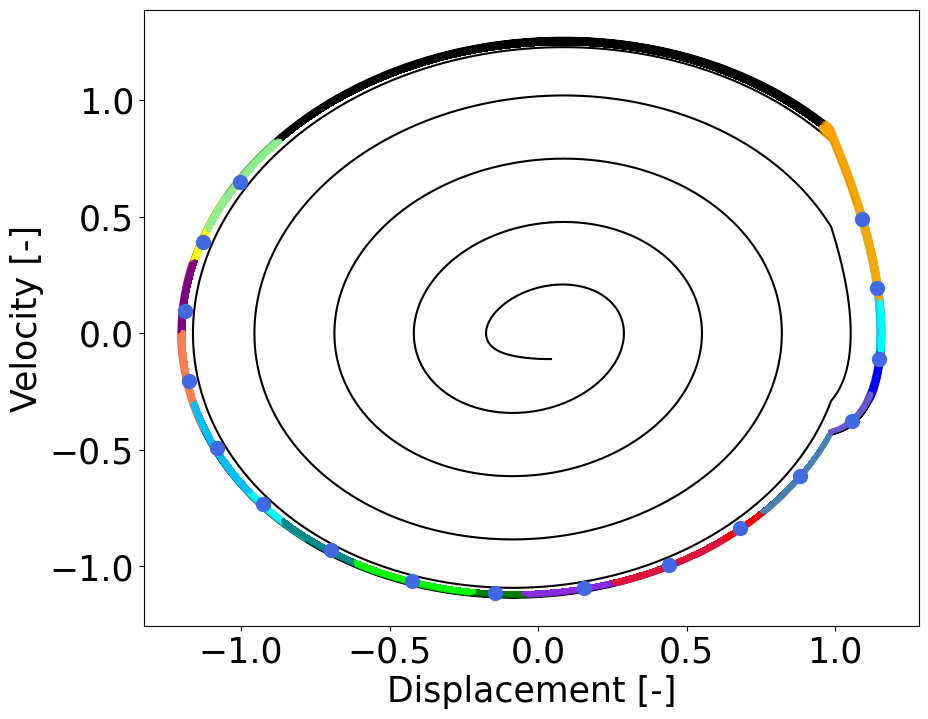

In [10]:
from itertools import cycle
set_plot_style()

traject = 0

fig, axs = plt.subplots(1, 1, figsize=(10, 8))

# plt.axvline(x=(1-a0), color='black', linestyle='--', label=f'Intermolecular Dist')
axs.plot(x_train_DMT_mult_traj[traject][:,0], x_train_DMT_mult_traj[traject][:,1], color = 'black', linewidth=1.5, alpha = 1, zorder=1)

colors = cycle(['yellow', 'blue', 'red', 'green', 'cyan', 'purple', 'aqua', 'steelblue', 'blueviolet', 'darkcyan', 'coral',
    'lightgreen', 'orange', 'slateblue', 'crimson', 'lime', 'deepskyblue'
])

for cluster in range(len(mult_traj_clusters_sections[traject])):
    current_color = next(colors)  # Get the next color from the cycle
    for cluster_dot in range(len(mult_traj_clusters_sections[traject][cluster])):
        axs.plot(mult_traj_clusters_sections[traject][cluster][cluster_dot][:,0], mult_traj_clusters_sections[traject][cluster][cluster_dot][:,1], color = current_color, linewidth=2.5, alpha =0.6, zorder=2)
    axs.plot(mult_traj_cluster_centers_x[traject][cluster], mult_traj_cluster_centers_y[traject][cluster], '.', color = 'royalblue', markersize = 20, zorder=3)

axs.set_xlabel(r'Displacement [-]', fontsize=25)
axs.set_ylabel(r'Velocity [-]', fontsize=25)

# Customizing tick labels size
axs.tick_params(axis='both', which='major', labelsize=25)  # Customize the font size of the tick labels
axs.tick_params(axis='both', which='major', labelsize=25)  # Customize the font size of the tick label

# Saving the figure with a transparent background
# plt.savefig('Fig_1_DMT_synthetic_data_phase_space_mult_clusters_w_centers_no_symbols_17_clusters_XX.png', transparent=True, dpi=300, bbox_inches='tight')

# Import trained models in clusters

In [11]:
found_models_df = pd.DataFrame(columns=['Candidate Model', 'Model Type', 'Serial No.', 'Cluster No.', 'Lambda', 'Nu', 'Parsimony'])
found_models_df = import_trained_models_from_folder_to_dataframe(folder_path = '/Users/santiago/Documents/PhD_documents/Python_Simulations/Learning_SINDy/Github_Repository',
                                                                 folder_name = 'repulsive_model_with_viscoelastic_terms_17_clusters',
                                                                 new_dataframe = found_models_df, number_of_parsimony_eq = 2)

### Divide data in Dataframe accourding to their Clusters

In [12]:
# Filter rows where 'Cluster No.' is 1
found_models_C1_df = found_models_df[found_models_df['Cluster No.'] == '1'].copy()

# Filter rows where 'Cluster No.' is 6
found_models_C6_df = found_models_df[found_models_df['Cluster No.'] == '6'].copy()

# Filter rows where 'Cluster No.' is 12
found_models_C12_df = found_models_df[found_models_df['Cluster No.'] == '12'].copy()

# Filter rows where 'Cluster No.' is 13
found_models_C13_df = found_models_df[found_models_df['Cluster No.'] == '13'].copy()

## Analysis for Cluster No. 1

In [13]:
found_models_C1_df = mark_unique_models_in_dataframe(found_models_C1_df)

# Now filter unique models:
unique_models_C1_df = found_models_C1_df[found_models_C1_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C1_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



### Checking repeated models

In [14]:
repeated_models_C1_df = found_models_C1_df[~found_models_C1_df['Is Unique']]
print('A total of ' + str(len(repeated_models_C1_df['Candidate Model'])) + ' repeated models were found')
print('')

A total of 0 repeated models were found



## AIC analysis for all models within one cluster: Cluster 1

In [15]:
unique_models_to_analyze = unique_models_C1_df
analyzed_cluster = 1

simulated_information_C1, error_information_C1, AIC_models_in_cluster_C1 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-3,
                    solve_ivp_method = 'BDF', model_type = 'Viscoelastic DMT', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C1 = get_relative_AIC_c_score(AIC_models_in_cluster_C1)

unique_models_C1_df['Delta_AIC_c'] = rel_AIC_c_lst_C1

Processing models: 100%|██████████| 100/100 [00:19<00:00,  5.06model/s]


## Best models within Cluster 1

Here there are the models that have a $\Delta \text{AIC}_c < 3$. Which means that the loss of information is small when simulating the found model. 

In [16]:
# Filter rows where 'Delta AIC_c' is less than 3
best_rel_AIC_c_C1_df = unique_models_C1_df[unique_models_C1_df['Delta_AIC_c'] < 3].reset_index(drop=True)
best_rel_AIC_c_C1_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

,Serial No.,Cluster No.,Parsimony,Lambda,Nu,Delta_AIC_c
0,18-02-25-041-1,1,8,7.742636826811278e-07,0.01291549665014884,1.304357
1,18-02-25-063-1,1,8,5.994842503189409e-06,0.0774263682681127,0.772708
2,18-02-25-023-1,1,8,1.6681005372000593e-05,0.0774263682681127,2.714581
3,18-02-25-077-1,1,7,0.00012915496650148828,0.021544346900318832,1.971770
4,18-02-25-050-1,1,8,0.00035938136638046257,0.01,2.083863
5,19-02-25-095-1,1,8,4.641588833612772e-05,0.027825594022071243,1.582062
6,18-02-25-018-1,1,7,0.001,0.1,2.062487
7,18-02-25-071-1,1,8,0.00012915496650148828,0.01291549665014884,2.790180
8,18-02-25-086-1,1,8,2.1544346900318822e-06,0.016681005372000592,2.554429
9,18-02-25-043-1,1,8,7.742636826811278e-07,0.0774263682681127,0.559076


## Simulation of one of these candidate models for cluster 1

rms was: 0.4452492329316788
switch_ind was: 68

Equation with length: 8
(e1)' = 1.000000000 e2
(e2)' = -0.149677338 1 + -1.000000000 e1 + -2.028500000 e2 + 0.087810173 sin(1*phase) + -1.484334568 (0.0132626-1+e1)^1.5 + -1.876465240 (0.0132626-1+e1)^2 + -2.133577141 (0.0132626-1+e1)^2.5 + 0.210736112 ((0.0132626-1+e1)^0.5)*e2
(phase)' = 1.000000000 1



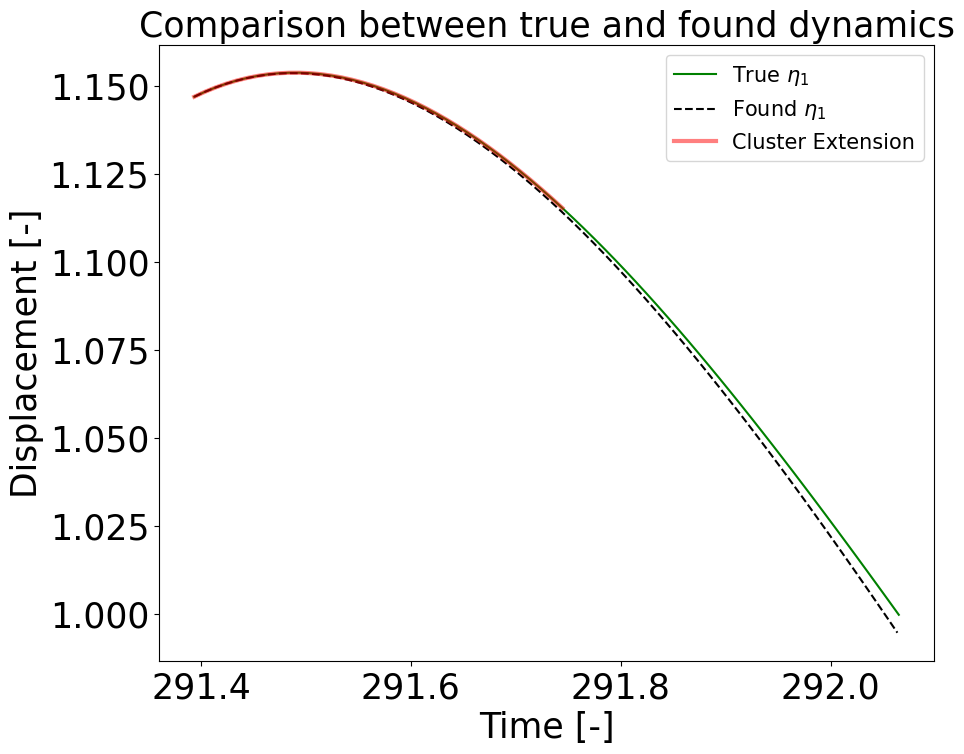

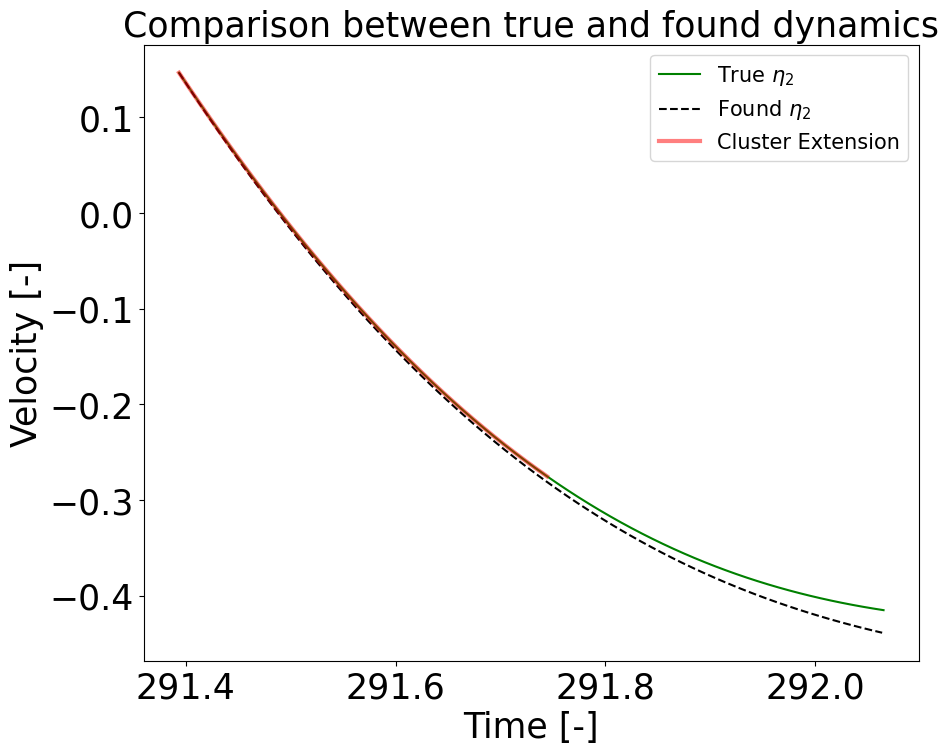

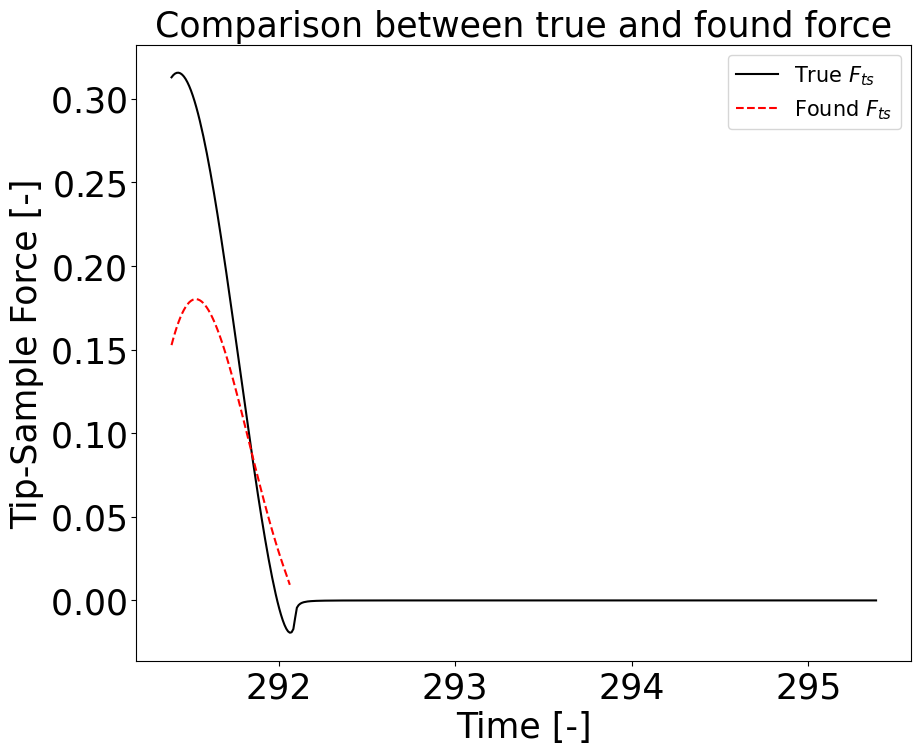

In [17]:
model_to_study = best_rel_AIC_c_C1_df['Candidate Model'][0]
cluster_to_test = 1

simulated_data_C1, extended_val_trajec_C1, F_ts_true_C1, F_ts_sim_C1 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3, force_plot_file_name = 'force_green', disp_plot_file_name = 'disp_green', vel_plot_file_name = 'vel_green',
                                                 plot = True, save=False)

## Analysis for Cluster No. 6

In [18]:
found_models_C6_df = mark_unique_models_in_dataframe(found_models_C6_df)

# Now filter unique models:
unique_models_C6_df = found_models_C6_df[found_models_C6_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C6_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 101 unique models were found



## AIC analysis for all models within one cluster: Cluster 6

In [19]:
unique_models_to_analyze = unique_models_C6_df
analyzed_cluster = 6

simulated_information_C6, error_information_C6, AIC_models_in_cluster_C6 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-3, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C6 = get_relative_AIC_c_score(AIC_models_in_cluster_C6)

unique_models_C6_df['Delta_AIC_c'] = rel_AIC_c_lst_C6

Processing models: 100%|██████████| 101/101 [00:20<00:00,  4.94model/s]


## Best models within Cluster 6

Here there are the models that have a $\Delta \text{AIC}_c < 3$. Which means that the loss of information is small when simulating the found model. 

In [20]:
# Filter rows where 'Delta AIC_c' is less than 3
pd.set_option('display.max_rows', None)
best_rel_AIC_c_C6_df = unique_models_C6_df[unique_models_C6_df['Delta_AIC_c'] < 3].reset_index(drop=True)
best_rel_AIC_c_C6_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

,Serial No.,Cluster No.,Parsimony,Lambda,Nu,Delta_AIC_c
0,19-02-25-004-6,6,8,1e-07,0.05994842503189409,2.706200
1,19-02-25-053-6,6,8,0.00035938136638046257,0.0774263682681127,2.887923
2,19-02-25-075-6,6,8,0.00012915496650148828,0.027825594022071243,2.936124
3,19-02-25-065-6,6,8,5.994842503189409e-06,0.027825594022071243,2.782354
4,19-02-25-066-6,6,8,5.994842503189409e-06,0.016681005372000592,0.000000
5,19-02-25-010-6,6,8,0.001,0.01,0.627923
6,19-02-25-073-6,6,8,0.00012915496650148828,0.0774263682681127,1.569503
7,19-02-25-002-6,6,8,1e-07,0.03593813663804628,1.525406
8,19-02-25-001-6,6,8,1e-07,0.01291549665014884,1.537758
9,19-02-25-011-6,6,8,0.001,0.01291549665014884,1.198360


## Simulation of one of these candidate models for cluster 6

rms was: 0.5091452117602134
switch_ind was: 67

Equation with length: 8
(e1)' = 1.000000000 e2
(e2)' = 0.251465170 1 + -1.000000000 e1 + -2.028500000 e2 + 0.087810173 sin(1*phase) + -9.384264024 (0.0132626-1+e1)^1.5 + 0.191663223 (0.0132626-1+e1)^2 + 8.465114935 (0.0132626-1+e1)^2.5 + -0.134477890 ((0.0132626-1+e1)^0.5)*e2
(phase)' = 1.000000000 1



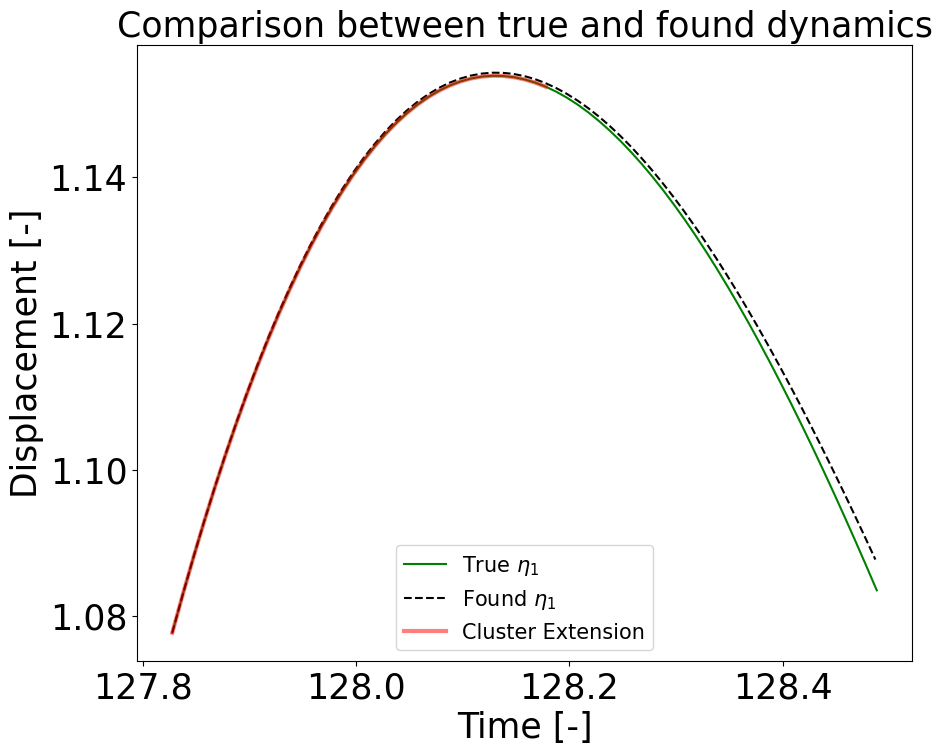

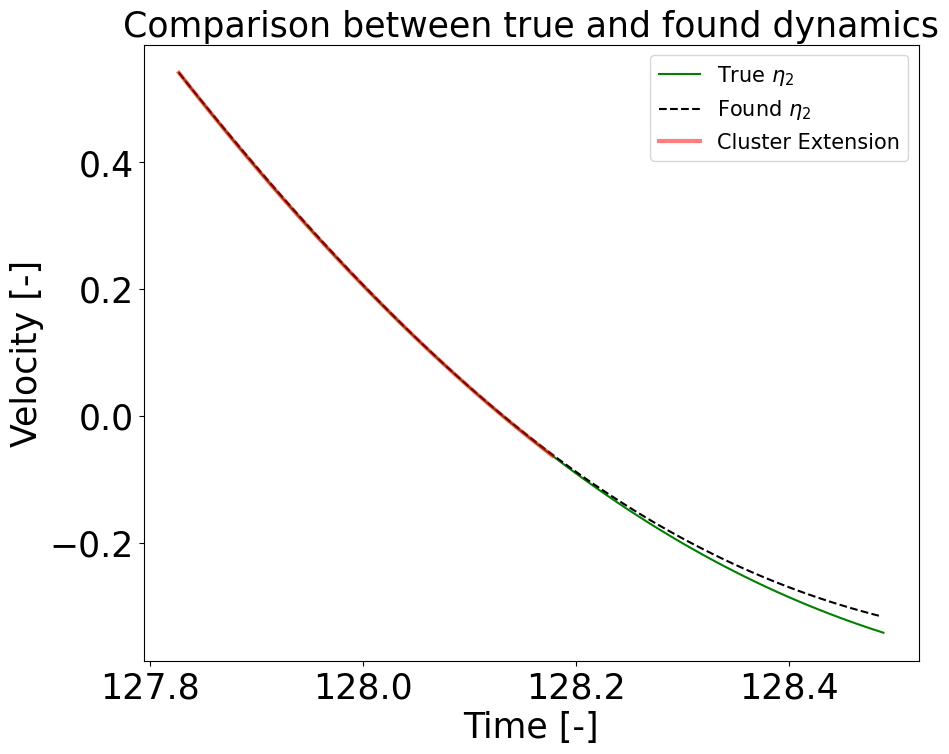

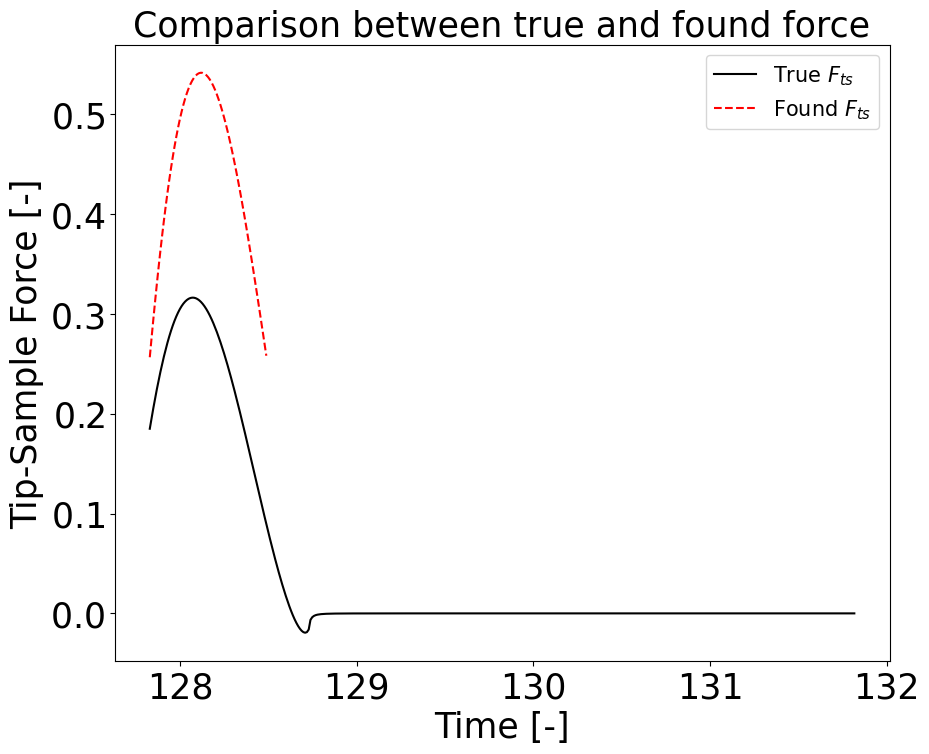

In [21]:
model_to_study = best_rel_AIC_c_C6_df['Candidate Model'][18]
cluster_to_test = 6

simulated_data_C6, extended_val_trajec_C6, F_ts_true_C6, F_ts_sim_C6 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 disp_plot_file_name= 'rep_aic_ts_disp_no_viscoelastic_terms', vel_plot_file_name = 'rep_aic_ts_vel_no_viscoelastic_terms', force_plot_file_name= 'rep_aic_ts_force_no_viscoelastic_terms',
                                                 plot = True, save=False)

## Analysis for Cluster No. 12

In [22]:
found_models_C12_df = mark_unique_models_in_dataframe(found_models_C12_df)

# Now filter unique models:
unique_models_C12_df = found_models_C12_df[found_models_C12_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C12_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 12

In [23]:
unique_models_to_analyze = unique_models_C12_df
analyzed_cluster = 12

simulated_information_C12, error_information_C12, AIC_models_in_cluster_C12 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-3, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C12 = get_relative_AIC_c_score(AIC_models_in_cluster_C12)

unique_models_C12_df['Delta_AIC_c'] = rel_AIC_c_lst_C12

Processing models: 100%|██████████| 100/100 [00:28<00:00,  3.56model/s]


## Best models within Cluster 12

Here there are the models that have a $\Delta \text{AIC}_c < 3$. Which means that the loss of information is small when simulating the found model. 

In [24]:
# Filter rows where 'Delta AIC_c' is less than 3
pd.set_option('display.max_rows', None)
best_rel_AIC_c_C12_df = unique_models_C12_df[unique_models_C12_df['Delta_AIC_c'] < 3].reset_index(drop=True)
best_rel_AIC_c_C12_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

,Serial No.,Cluster No.,Parsimony,Lambda,Nu,Delta_AIC_c
0,19-02-25-010-12,12,7,0.001,0.01,2.745041
1,19-02-25-061-12,12,8,5.994842503189409e-06,0.01291549665014884,2.811843
2,19-02-25-071-12,12,8,0.00012915496650148828,0.01291549665014884,2.714492
3,19-02-25-058-12,12,7,0.00035938136638046257,0.1,2.791036
4,19-02-25-007-12,12,9,1e-07,0.021544346900318832,0.000000
5,19-02-25-033-12,12,10,2.782559402207126e-07,0.0774263682681127,1.558009
6,19-02-25-049-12,12,9,7.742636826811278e-07,0.046415888336127774,1.977972
7,19-02-25-067-12,12,8,5.994842503189409e-06,0.021544346900318832,2.802870
8,19-02-25-096-12,12,8,4.641588833612772e-05,0.016681005372000592,2.747906
9,19-02-25-051-12,12,8,0.00035938136638046257,0.01291549665014884,2.969279


## Simulation of one of these candidate models for cluster 12

rms was: 0.4586628936204585
switch_ind was: 1

Equation with length: 7
(e1)' = 1.000000000 e2
(e2)' = 0.036631820 1 + -1.000000000 e1 + -2.028500000 e2 + 0.087810173 sin(1*phase) + -3.970301610 (0.0132626-1+e1)^1.5 + -0.393285740 (0.0132626-1+e1)^2 + 1.196114173 (0.0132626-1+e1)^2.5
(phase)' = 1.000000000 1



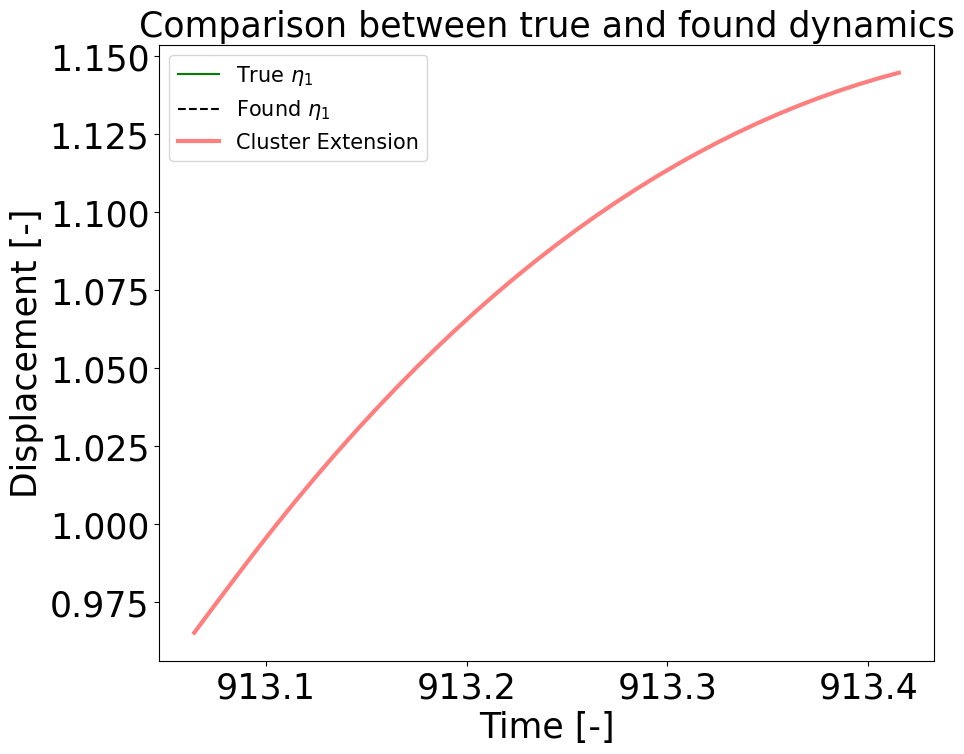

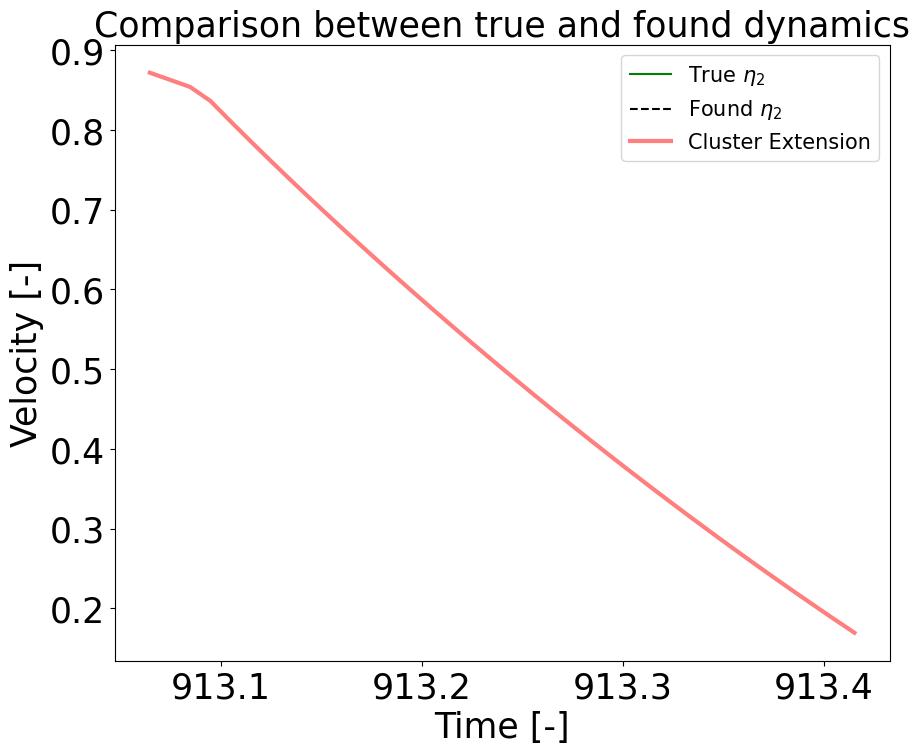

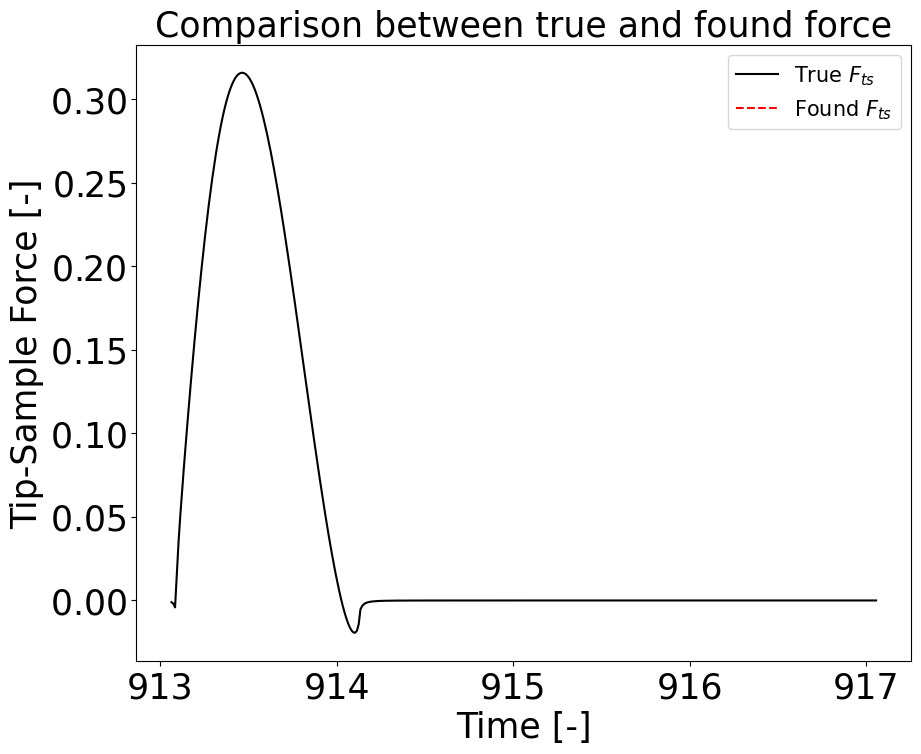

In [25]:
model_to_study = best_rel_AIC_c_C12_df['Candidate Model'][0]
cluster_to_test = 12

simulated_data_C12, extended_val_trajec_C12, F_ts_true_C12, F_ts_sim_C12 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

## Analysis for Cluster No. 13

In [26]:
found_models_C13_df = mark_unique_models_in_dataframe(found_models_C13_df)

# Now filter unique models:
unique_models_C13_df = found_models_C13_df[found_models_C13_df['Is Unique']].copy() # .copy() to ensure that unique_models_df is a standalone DataFrame, and modifications to it won't affect found_models_df.

print('A total of ' + str(len(unique_models_C13_df['Candidate Model'])) + ' unique models were found')
print('')

A total of 100 unique models were found



## AIC analysis for all models within one cluster: Cluster 13

In [27]:
unique_models_to_analyze = unique_models_C13_df
analyzed_cluster = 13

simulated_information_C13, error_information_C13, AIC_models_in_cluster_C13 = simulate_cluster_get_E_avg_until_ts_n_calculate_AIC_unique_models(
                    unique_models_df = unique_models_to_analyze, 
                    validation_trajectory_section = mult_traj_clusters_sections[traject][analyzed_cluster][10],
                    full_validation_trajectory = x_train_DMT_mult_traj[traject],
                    t_steps_beyond_cluster = 400, threshold_for_ts = 1e-3, model_type = 'Viscoelastic DMT',
                    solve_ivp_method = 'BDF', dt=dt, a0=a0, C1=C1, C2=C2, C3=C3)

rel_AIC_c_lst_C13 = get_relative_AIC_c_score(AIC_models_in_cluster_C13)

unique_models_C13_df['Delta_AIC_c'] = rel_AIC_c_lst_C13

Processing models: 100%|██████████| 100/100 [00:19<00:00,  5.08model/s]


## Best models within Cluster 13

Here there are the models that have a $\Delta \text{AIC}_c < 3$. Which means that the loss of information is small when simulating the found model. 

In [28]:
# Filter rows where 'Delta AIC_c' is less than 3
pd.set_option('display.max_rows', None)
best_rel_AIC_c_C13_df = unique_models_C13_df[unique_models_C13_df['Delta_AIC_c'] < 3].reset_index(drop=True)
best_rel_AIC_c_C13_df[['Serial No.', 'Cluster No.', 'Parsimony', 'Lambda', 'Nu', 'Delta_AIC_c']]

,Serial No.,Cluster No.,Parsimony,Lambda,Nu,Delta_AIC_c
0,19-02-25-012-13,13,8,0.001,0.03593813663804628,2.565136
1,19-02-25-042-13,13,8,7.742636826811278e-07,0.03593813663804628,2.946326
2,19-02-25-099-13,13,8,4.641588833612772e-05,0.046415888336127774,2.808220
3,19-02-25-050-13,13,8,0.00035938136638046257,0.01,1.482687
4,19-02-25-006-13,13,8,1e-07,0.016681005372000592,2.824207
5,19-02-25-046-13,13,8,7.742636826811278e-07,0.016681005372000592,1.691193
6,19-02-25-043-13,13,8,7.742636826811278e-07,0.0774263682681127,2.683547
7,19-02-25-083-13,13,8,2.1544346900318822e-06,0.0774263682681127,2.644758
8,19-02-25-085-13,13,8,2.1544346900318822e-06,0.027825594022071243,2.593078
9,19-02-25-022-13,13,8,1.6681005372000593e-05,0.03593813663804628,2.313645


## Simulation of one of these candidate models for cluster 13

rms was: 0.5326848672253837
switch_ind was: 41

Equation with length: 8
(e1)' = 1.000000000 e2
(e2)' = 0.016739044 1 + -1.000000000 e1 + -2.028500000 e2 + 0.087810173 sin(1*phase) + -3.098775881 (0.0132626-1+e1)^1.5 + -4.177899120 (0.0132626-1+e1)^2 + 3.385331215 (0.0132626-1+e1)^2.5 + 0.629369623 ((0.0132626-1+e1)^0.5)*e2
(phase)' = 1.000000000 1



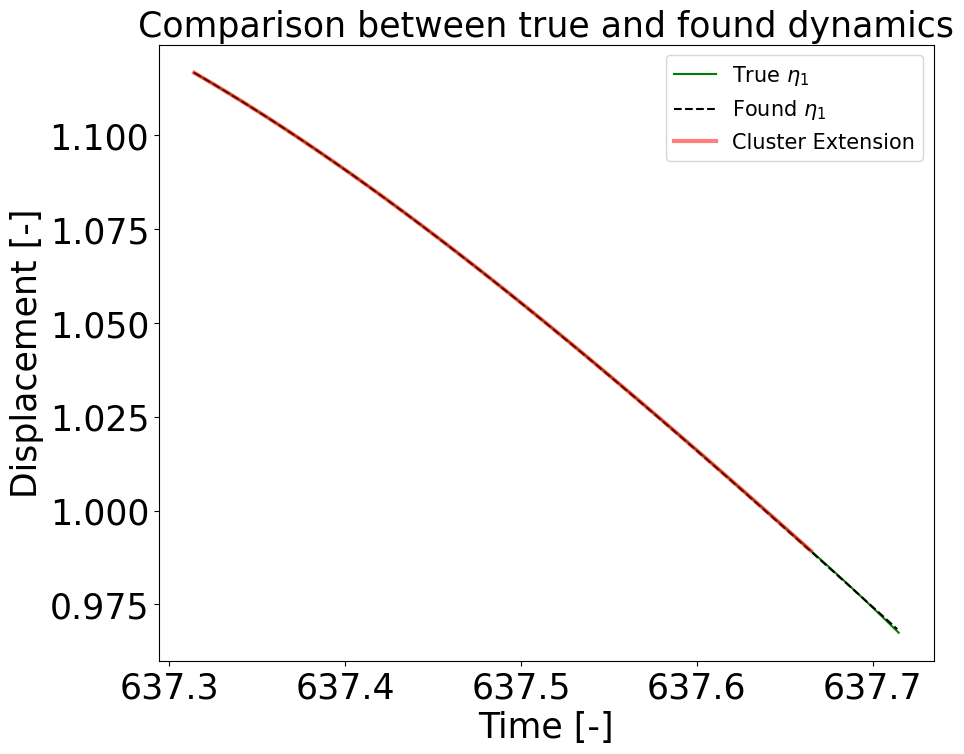

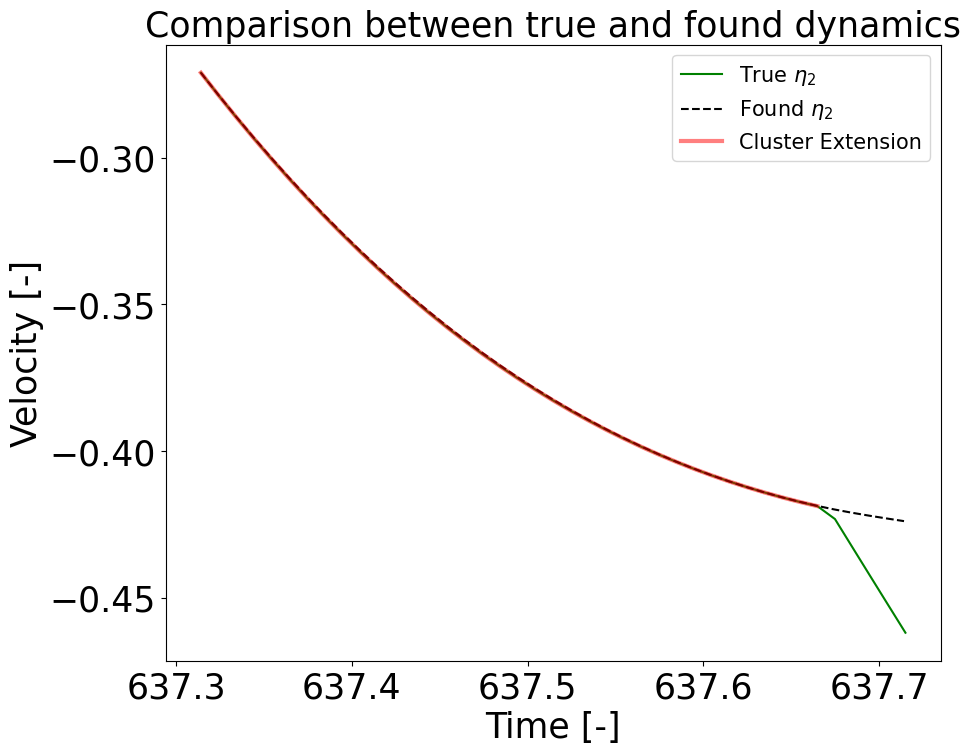

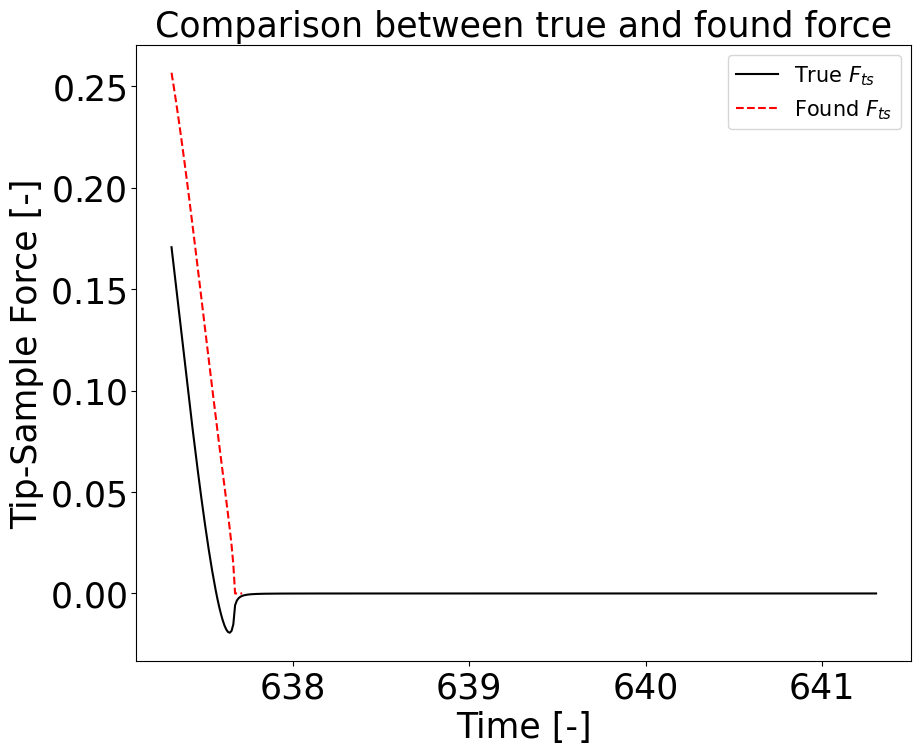

In [29]:
model_to_study = best_rel_AIC_c_C13_df['Candidate Model'][0]
cluster_to_test = 13

simulated_data_C13, extended_val_trajec_C13, F_ts_true_C13, F_ts_sim_C13 = simulate_results_from_cluster_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 400, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3,
                                                 plot = True)

______________________________________________________________________________________________________________________________________________________________

# Analysis of best models across all clusters

The purpose of this section is to analyze all the best models identified by the $\Delta AIC_{c}$ analysis. To achieve this, the algorithm counts the occurrences of these best models while also remembering their respective clusters. 

## Concatenation of best $\Delta AIC_{c}$ models

Here, the code is grouping or concatenating all the previus dataframes containing only those models which scored a $\Delta AIC_{c} < 3$. Therefore, this dataframe contained the library of best scored candidate models for describing the dynamics of the system. 

In [30]:
# List of the DataFrames
dataframes = [
    best_rel_AIC_c_C1_df,
    best_rel_AIC_c_C6_df,
    best_rel_AIC_c_C12_df,
    best_rel_AIC_c_C13_df,
]

# Concatenate all DataFrames into one dataframe containing all best found models. 
best_models_in_all_clusters_df = pd.concat(dataframes, ignore_index=True)

### Found Features extraction from best models in all clusters dataframe

In [31]:
# Add a column for the extracted found candidate functions lists
best_models_in_all_clusters_df['Found Features'] = best_models_in_all_clusters_df['Candidate Model'].apply(extract_active_cand_functions_from_found_eq)

# Count the occurrences of each unique list with found candidate functions
best_models_in_all_clusters_df['Found Features (Tuple)'] = best_models_in_all_clusters_df['Found Features'].apply(tuple)
found_features_counts = best_models_in_all_clusters_df['Found Features (Tuple)'].value_counts()

# Map the counts back to the dataframe using the tuple version of 'Found Features'
best_models_in_all_clusters_df['occurrence'] = best_models_in_all_clusters_df['Found Features (Tuple)'].map(found_features_counts)

### Found Model types with the occurence in the phase space

In [32]:
# Drop duplicates based on 'Found Features'
unique_filtered_df = best_models_in_all_clusters_df.drop_duplicates(subset=['Found Features'])

# Reset the index and start from 10
unique_filtered_df = unique_filtered_df[['Serial No.', 'occurrence', 'Parsimony', 'Found Features']].reset_index(drop=True)
unique_filtered_df.index = range(10, 10 + len(unique_filtered_df))
unique_filtered_df

,Serial No.,occurrence,Parsimony,Found Features
10,18-02-25-041-1,198,8,"[1, x0, x1, sin(1*x2), (0.0132626-1+x0)^1.5, (..."
11,18-02-25-077-1,6,7,"[1, x0, x1, sin(1*x2), (0.0132626-1+x0)^1.5, (..."
12,18-02-25-013-1,1,7,"[1, x0, x1, sin(1*x2), (0.0132626-1+x0)^2, (0...."
13,19-02-25-015-6,2,7,"[1, x0, x1, sin(1*x2), (0.0132626-1+x0)^1.5, (..."
14,19-02-25-016-6,1,6,"[1, x0, x1, sin(1*x2), (0.0132626-1+x0)^1.5, (..."
15,19-02-25-058-12,3,7,"[x0, x1, sin(1*x2), (0.0132626-1+x0)^1.5, (0.0..."
16,19-02-25-007-12,3,9,"[1, x0, x1, sin(1*x2), (1-x0)^-2, (0.0132626-1..."
17,19-02-25-033-12,1,10,"[1, x0, x1, sin(1*x2), (1-x0)^-2, (1-x0)^-3, (..."


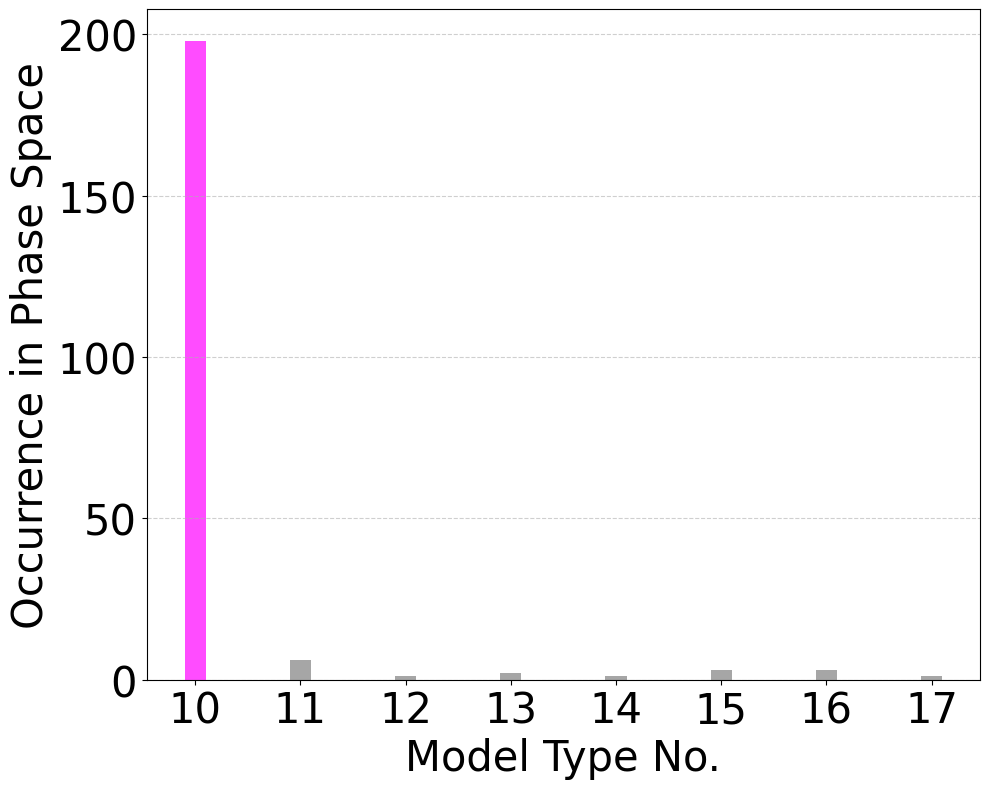

In [33]:
unique_models_test_df = unique_filtered_df

# Predefined color list for occurrences > 2
color_above_2 = ['magenta', 'red', 'green', 'orange', 'purple', 'navy', 'cyan', 'yellow', 'brown', 'pink']

# Assign colors based on the threshold (>2) without repeating
color_iter = iter(color_above_2)
colors = [
    next(color_iter) if val > 7 else 'grey'
    for val in unique_models_test_df['occurrence']
]

# Create the bar plot
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
axs.bar(unique_models_test_df.index, unique_models_test_df['occurrence'], color=colors, alpha=0.7, width=0.2)

# Add labels and title
plt.xlabel('Model Type No.', fontsize=30)
plt.ylabel('Occurrence in Phase Space', fontsize=30)

# Define the range of x-ticks based on the actual indices of your DataFrame
x_ticks = unique_models_test_df.index
axs.set_xticks(x_ticks)  
plt.xticks(rotation=0, fontsize=25)
axs.grid(axis='y', linestyle='--', alpha=0.6)
axs.tick_params(axis='both', which='major', labelsize=30)

# Display the plot
plt.tight_layout()
disp_plot_file_name = 'occurance_plot_with_found_features_repulsive'
# axs.set_title('Library of Most Predominant Model Types \n Across Clusters After $\Delta AIC_{c}$ Analysis', fontsize=25)

# plt.savefig(disp_plot_file_name + '.png', dpi=300, bbox_inches='tight', transparent=True)

# Simulation of results in the Phase Space

rms was: 0.6877609032564788
switch_ind was: 94


'0.004333277 1 + -1.000000000 e1 + -2.028500000 e2 + 0.087810173 sin(1*phase) + -4.217108005 (0.0132626-1+e1)^1.5 + -0.696047300 (0.0132626-1+e1)^2 + 1.628901382 (0.0132626-1+e1)^2.5 + 0.391838772 ((0.0132626-1+e1)^0.5)*e2'

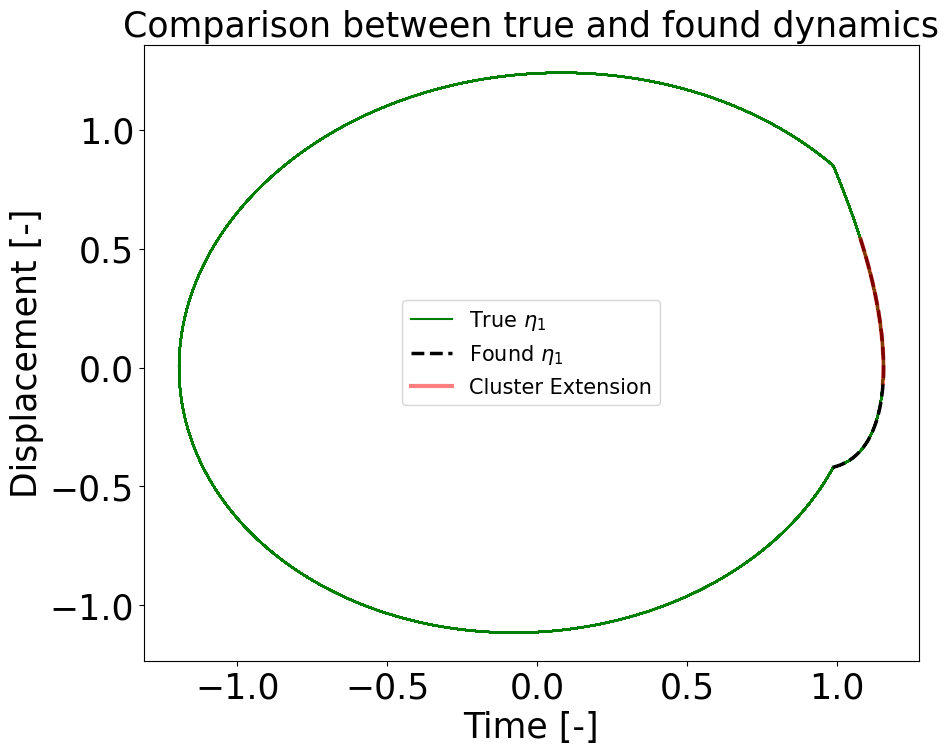

In [34]:
model_to_study = best_rel_AIC_c_C6_df['Candidate Model'][0] #14
cluster_to_test = 6

simulated_data_C6F, extended_val_trajec_C6F, F_ts_true_C6F, F_ts_sim_C6F = simulate_phase_space_from_most_freq_models_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= (1e-2)/2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 807, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3, #'BDF'
                                                 plot = True, save=False)

model_to_study.equations(precision=9)[1]

Text(0.5, 1.0, 'AFM DMT Synthetic Data Phase Space with \n Most Predominant Model Types from Training Clusters')

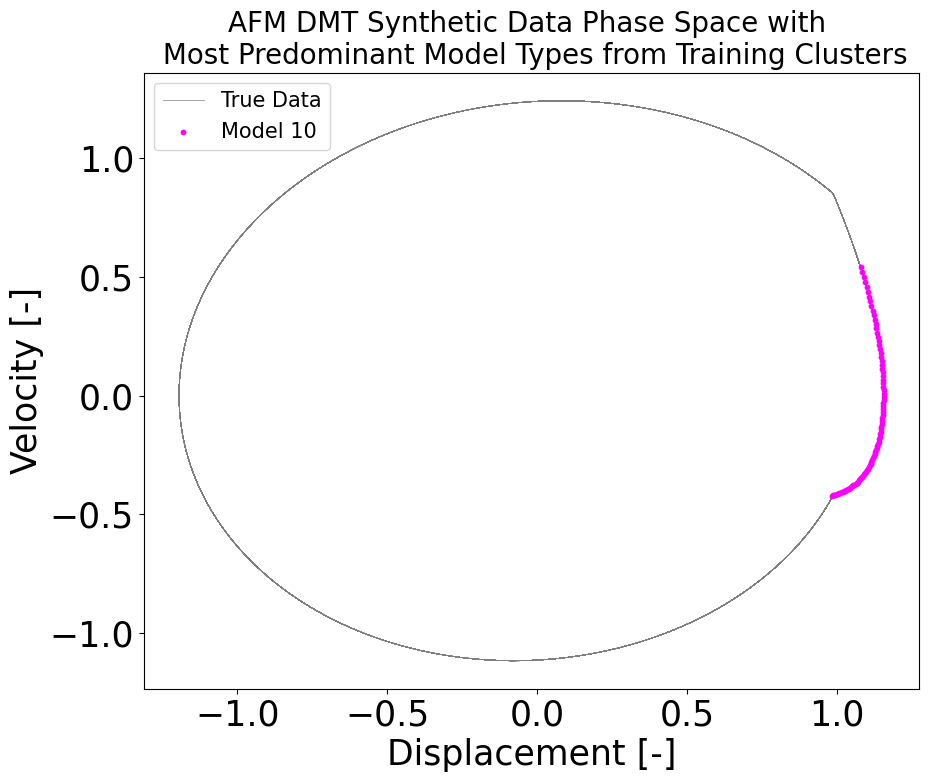

In [35]:
set_plot_style()

fig, axs = plt.subplots(1, 1, figsize=(10, 8))
# Plot the gray points first with the lowest zorder
axs.plot(x_train_DMT_mult_traj[traject][-16000:,0], x_train_DMT_mult_traj[traject][-16000:,1], color='black', linewidth = 0.5, alpha = 0.5, label = 'True Data', zorder=1)
axs.scatter(simulated_data_C6F[:, 0], simulated_data_C6F[:, 1], s=10, alpha = 1, color = 'magenta', label = 'Model 10', zorder=2)

axs.set_xlabel(r'Displacement [-]', fontsize=25)
axs.set_ylabel(r'Velocity [-]', fontsize=25)
axs.tick_params(axis='both', which='major', labelsize=25)

axs.legend(loc='upper left', fontsize=15)
axs.set_title('AFM DMT Synthetic Data Phase Space with \n Most Predominant Model Types from Training Clusters', fontsize=20)

# Saving the figure with a transparent background
# plt.savefig('DMT_phase_space_found_models_simulations_best_repulsive.png', transparent=True, dpi=300, bbox_inches='tight')

### Import best attractive model

In [37]:
best_att_model = import_single_trained_model_from_folder(folder_path = '/Users/santiago/Documents/PhD_documents/Python_Simulations/Learning_SINDy/Github_Repository',
                                                         folder_name = 'attractive_model_with_viscoelastic_terms_17_clusters', 
                                                         file_name = 'constr_attmodel_DMTvisc_SN_06-02-25-020-7_cluster_7_lambda_2.782559402207126e-07_nu_0.01_.dill')

rms was: 0.0030923134310008485
switch_ind was: 525


'0.000009789 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.000001347 (1-e1)^-2'

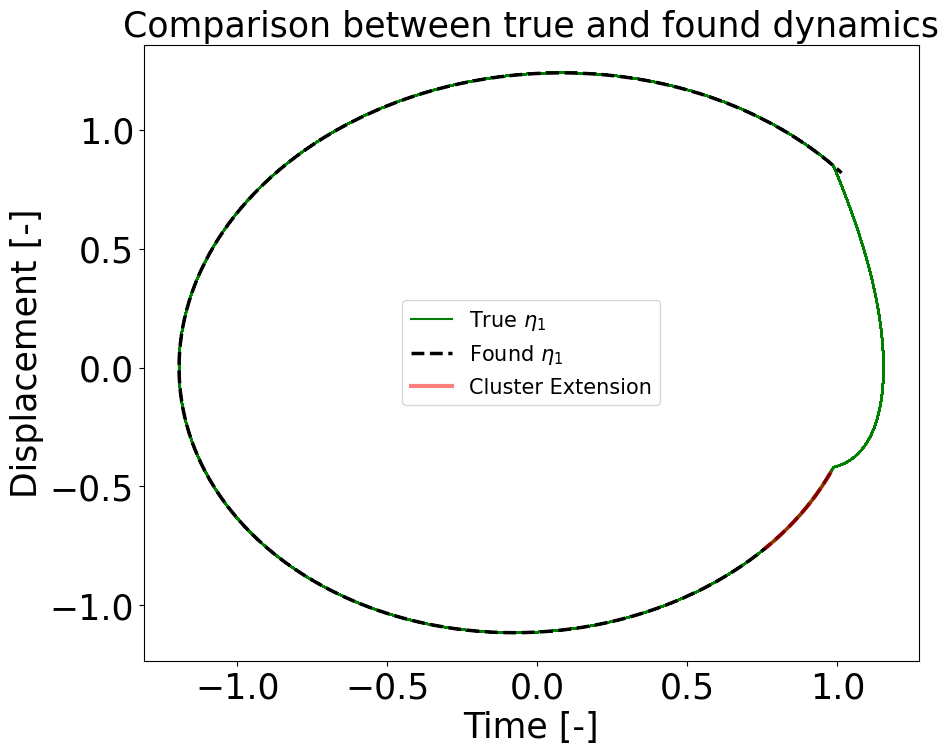

In [38]:
model_to_study = best_att_model
cluster_to_test = 7

simulated_data_att, extended_val_trajec_att, F_ts_true_att, F_ts_sim_att = simulate_phase_space_from_most_freq_models_until_ts(model_to_simulate = model_to_study,
                                                 validation_trajectory_section = mult_traj_clusters_sections[traject][cluster_to_test][10],
                                                 full_validation_trajectory = x_train_DMT_mult_traj[traject], threshold_for_ts= 1e-2,
                                                 solve_ivp_method = 'BDF', dt=dt, t_steps_beyond_cluster = 525, model_type = 'Viscoelastic DMT',
                                                 a0=a0, C1=C1, C2=C2, C3=C3, #'BDF'
                                                 plot = True, save=False)

model_to_study.equations(precision=9)[1]

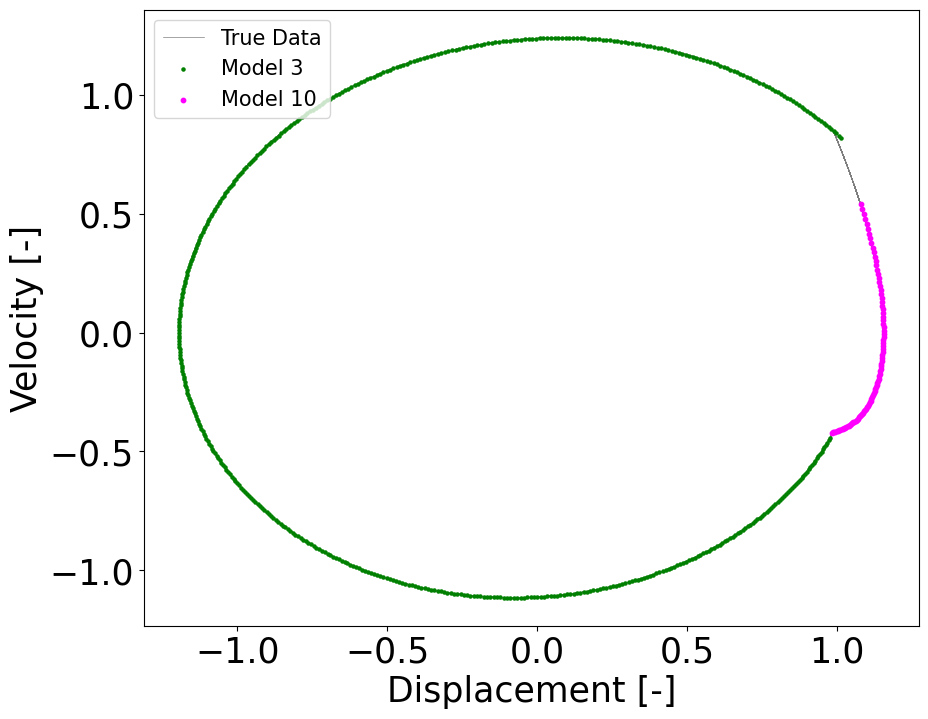

In [39]:
set_plot_style()

fig, axs = plt.subplots(1, 1, figsize=(10, 8))
axs.plot(x_train_DMT_mult_traj[traject][-16000:,0], x_train_DMT_mult_traj[traject][-16000:,1], color='black', linewidth = 0.5, alpha = 0.5, label = 'True Data', zorder=1)
axs.scatter(simulated_data_att[:, 0], simulated_data_att[:, 1], s=5, color = 'green', label = 'Model 3', zorder=4)
axs.scatter(simulated_data_C6F[:, 0], simulated_data_C6F[:, 1], s=10, alpha = 1, color = 'magenta', label = 'Model 10', zorder=2)
axs.set_xlabel(r'Displacement [-]', fontsize=25)
axs.set_ylabel(r'Velocity [-]', fontsize=25)
axs.tick_params(axis='both', which='major', labelsize=25)
axs.legend(loc='upper left', fontsize=15)
# axs.set_title('AFM DMT Synthetic Data Phase Space with \n Two Best Model Types from Training Clusters', fontsize=20)

# Saving the figure with a transparent background
# plt.savefig('DMT_phase_space_found_models_simulations_repulsive_and_attractive_viscDMT.png', transparent=True, dpi=300, bbox_inches='tight')

# Simulate found equations

In [40]:
print('The best attractive model is: ')
print(best_att_model.equations(precision = 9)[1])
print(' ')
print('The best repulsive model is: ')
print(best_rel_AIC_c_C6_df['Candidate Model'][0].equations(precision = 9)[1])

The best attractive model is: 
0.000009789 1 + -1.000000000 e1 + -0.001700000 e2 + 0.087810173 sin(1*phase) + 0.000001347 (1-e1)^-2
 
The best repulsive model is: 
0.004333277 1 + -1.000000000 e1 + -2.028500000 e2 + 0.087810173 sin(1*phase) + -4.217108005 (0.0132626-1+e1)^1.5 + -0.696047300 (0.0132626-1+e1)^2 + 1.628901382 (0.0132626-1+e1)^2.5 + 0.391838772 ((0.0132626-1+e1)^0.5)*e2


### Creating function with found results

In [41]:
def found_complete_equations(t, y, a0, d1, d2, B1, y_bar, forcing_freq):
    
    eta_1, eta_2, phase = y

    deta1dt = eta_2

    if 1-eta_1 <= a0: 
        deta2dt = 0.004333277 - eta_1 - (d2*eta_2) + y_bar * (forcing_freq) ** 2 * B1 * np.sin(phase) - 4.217108005*((a0-(1 - eta_1))**(1.5)) - 0.696047300*((a0-(1 - eta_1))**(2)) + 1.628901382*((a0-(1 - eta_1))**(2.5)) + 0.391838772*(((a0-(1 - eta_1))**(0.5))*eta_2)
    else: 
        deta2dt = 0.000009789 - eta_1 - (d1*eta_2) + y_bar * (forcing_freq)** 2 * B1 * np.sin(phase) + 0.000001347*((1-eta_1)**(-2))
    dphase_dt = forcing_freq

    return [deta1dt, deta2dt,dphase_dt] 

In [42]:
def calculate_AFM_DMT_Force_found(eta_1, eta_2, a0):
    
    if 1-eta_1 <= a0: 
        F_ts_temp = - 4.217108005*((a0-(1 - eta_1))**(1.5)) - 0.696047300*((a0-(1 - eta_1))**(2)) + 1.628901382*((a0-(1 - eta_1))**(2.5)) - 0.391838772*(((a0-(1 - eta_1))**(0.5))*eta_2)
    else: 
        F_ts_temp = 0.000001347*((1-eta_1)**(-2))

    return F_ts_temp 

### Simulation of found model (attractive and repulsive)

In [43]:
dt = 0.01 
t_train_DMT = np.arange(0, 1000, dt) #time until 1000 steps
init_cond_DMT = init_cond_list[0] # Initial conditions for position and velocity respectibly
t_train_span_DMT = (t_train_DMT[0], t_train_DMT[-1])  # Time span for the simulation

found_AFM_DMT_ivp = solve_ivp(found_complete_equations, t_train_span_DMT, init_cond_DMT, t_eval=t_train_DMT, args=(a0,d1,d2, B1, y_bar,forcing_freq), rtol=1e-6, atol=1e-8, method = 'RK45', dense_output=True)
x_found_DMT = found_AFM_DMT_ivp.y.T
t_found_DMT_ivp = found_AFM_DMT_ivp.t

print('Verifying convergence by checking time length')
print(x_found_DMT.shape)
print(t_found_DMT_ivp.shape)
print(t_train_DMT.shape)
print('')
print('Verifying same time arrays for both solve_ipv() and t_train_DMT')
print(t_train_DMT[-5:])
print(t_found_DMT_ivp[-5:])
print('')

Verifying convergence by checking time length
(100000, 3)
(100000,)
(100000,)

Verifying same time arrays for both solve_ipv() and t_train_DMT
[999.95 999.96 999.97 999.98 999.99]
[999.95 999.96 999.97 999.98 999.99]



#### Cantilever beam data:

In [44]:
eta_star = 8.88249 #in [nm] for a system: Si-Si Region II (Rützel, S. & Raman, A., 2002)
w_0_cant = 2*np.pi*11.086e3 #first natural frequency of cantilever in [rad/s] (Rützel, S. & Raman, A., 2002)
Q_factor = 100 #In air for a system: Si-Si Region II (Rützel, S. & Raman, A., 2002)
cant_length = 449e-6 #in [nm] taken from table 1 of (Rützel, S. & Raman, A., 2002)
cant_width = 46e-6 #in [μm] taken from table 1 of (Rützel, S. & Raman, A., 2002)
cant_thickness = 1.7e-6 #in [μm] taken from table 1 of (Rützel, S. & Raman, A., 2002)
cant_density = 2330 #in [kg/m^3] taken from table 1 of (Rützel, S. & Raman, A., 2002)
E_modulus = 176e9 #in [Pa] taken from table 1 of (Rützel, S. & Raman, A., 2002)

cant_inertia = (1/12)*(cant_width)*(cant_thickness**3)
k_eff_cant = (3*E_modulus*cant_inertia)/(cant_length)

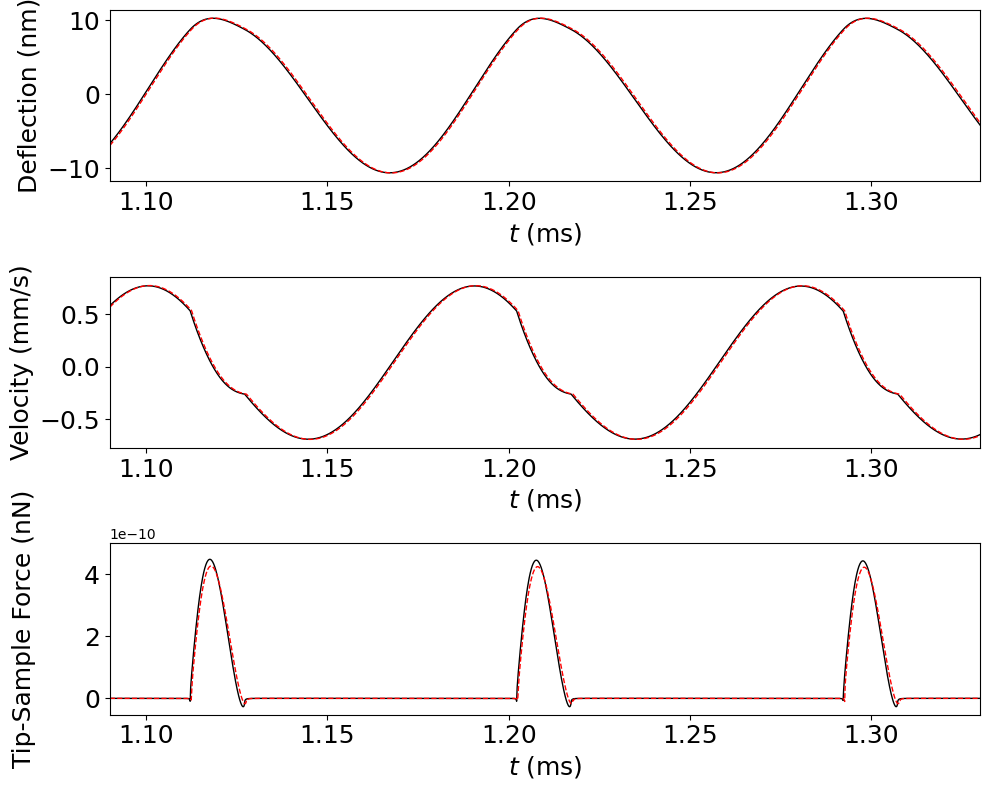

In [45]:
import matplotlib.ticker as mticker

signal = x_train_DMT_mult_traj[0]
time = x_train_DMT_mult_traj[0][:,2]

#Calculations to set the units back on the equation results
x_train_true_disp, true_t_train_DMT = get_true_AFM_displacement(signal[:,0], eta_star, tau_array=time, omega_0=w_0_cant)
x_train_true_vel, true_t_train_DMT = get_true_AFM_velocity(signal[:,1], eta_star, tau_array=time, omega_0=w_0_cant)
x_train_true_vel = x_train_true_vel*(1e-9)*(1000) #for velcolity in [mm/s]

#Calculations to set the units back on the equation results
x_train_true_disp_sim, true_t_train_DMT = get_true_AFM_displacement(x_found_DMT[:,0], eta_star, tau_array=time, omega_0=w_0_cant)
x_train_true_vel_sim, true_t_train_DMT = get_true_AFM_velocity(x_found_DMT[:,1], eta_star, tau_array=time, omega_0=w_0_cant)
x_train_true_vel_sim = x_train_true_vel_sim*(1e-9)*(1000) #for velcolity in [mm/s]

#Calculations on the force
F_ts_true = calculate_true_F_ts_DMT_viscoelast_damp(sim_disp_data=x_train_DMT_mult_traj[0], a0=a0, C1=C1, C2=C2, C3=C3)
F_ts_true_sim = calculate_true_F_ts_DMT_found(sim_disp_data=x_found_DMT, a0=a0)

F_ts_true_w_units, _ = get_true_AFM_Tip_Sample_Force(afm_force_array=F_ts_true, eta_star=eta_star, tau_array = time, omega_0=w_0_cant, 
                                                  cant_density=cant_density, cant_width=cant_width, cant_thickness=cant_thickness, cant_length=cant_length)
F_ts_true_w_units = F_ts_true_w_units*1e9 # to convert to nN.

F_ts_sim_w_units, _ = get_true_AFM_Tip_Sample_Force(afm_force_array=F_ts_true_sim, eta_star=eta_star, tau_array = time, omega_0=w_0_cant, 
                                                  cant_density=cant_density, cant_width=cant_width, cant_thickness=cant_thickness, cant_length=cant_length)
F_ts_sim_w_units = F_ts_sim_w_units*1e9 # to convert to nN.

time_in_ms = true_t_train_DMT * 1000

# Setup the figure and subplots
set_plot_style()
fig, axs = plt.subplots(3, 1, figsize=(10, 8)) 

# First subplot for Position
axs[0].plot(time_in_ms, x_train_true_disp, linewidth=1.0, label= r'Original Deflection', color = 'black')
axs[0].plot(time_in_ms, x_train_true_disp_sim, linewidth=1.0, label=r'Idenfitied Deflection', color = 'red', linestyle = '--')
axs[0].set_xlabel(r'$t$ (ms)', fontsize=18)   
axs[0].set_ylabel(r'Deflection (nm)', fontsize=18)  
axs[0].set_xlim([1.09, 1.33]) 
axs[0].tick_params(axis='both', which='major', labelsize=18)

# Second subplot for Velocity
axs[1].plot(time_in_ms, x_train_true_vel, linewidth=1.0, label=r'Original Velocity', color = 'black')
axs[1].plot(time_in_ms, x_train_true_vel_sim, linewidth=1.0, label=r'Identified Velocity', color = 'red', linestyle = '--')
axs[1].set_xlabel(r'$t$ (ms)', fontsize=18)
axs[1].set_ylabel(r'Velocity (mm/s)', fontsize=18)
axs[1].set_xlim([1.09, 1.33])
axs[1].tick_params(axis='both', which='major', labelsize=18)

# Third subplot for Force
axs[2].plot(time_in_ms, F_ts_true_w_units, linewidth=1.0, label=r'Original Force', color = 'black')
axs[2].plot(time_in_ms, F_ts_sim_w_units, linewidth=1.0, label=r'Identified Force', color = 'red', linestyle = '--')
axs[2].set_xlabel(r'$t$ (ms)', fontsize=18)
axs[2].set_ylabel(r'Tip-Sample Force (nN)', fontsize=18, labelpad=35)
axs[2].set_xlim([1.09, 1.33])
axs[2].tick_params(axis='both', which='major', labelsize=18)

plt.tight_layout() # Adjust layout to prevent overlap
file_name = 'x_train_viscDMT_single_traj_vs_simulated_found_dis_vel_force_2_colors'
# plt.savefig(f't_{file_name}.png', dpi=300, transparent = True, bbox_inches='tight')

### 3D Steady-State Phase Space

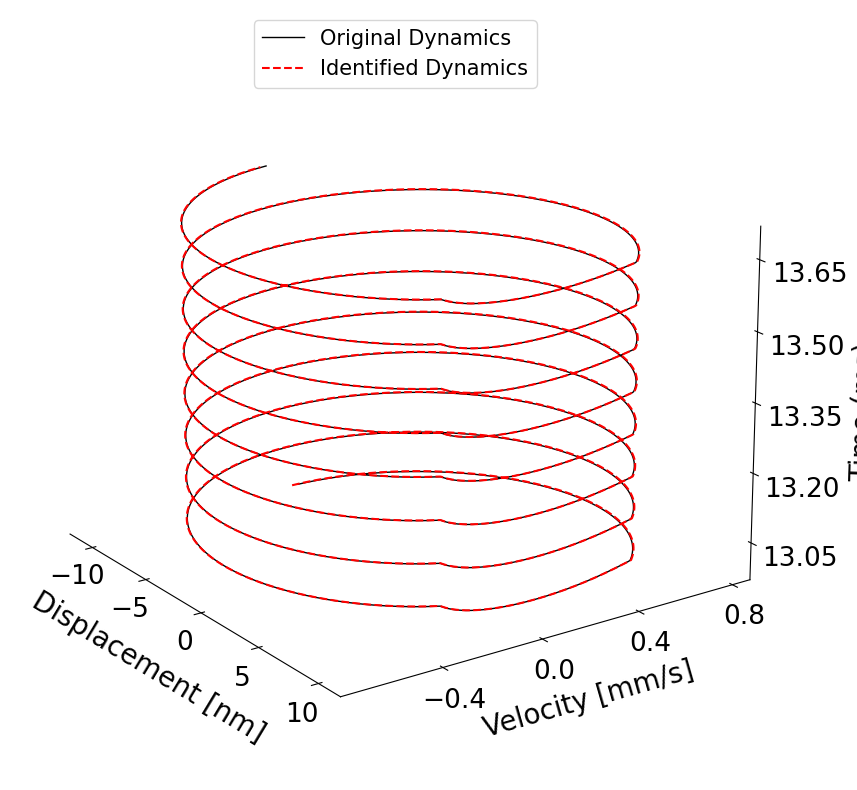

In [46]:
from matplotlib.ticker import MaxNLocator

# Filter data to ensure z-values are within the specified limits
mask = (t_train_DMT >= 900) & (t_train_DMT <= 950)
filtered_disp = x_train_true_disp[mask]
filtered_vel = x_train_true_vel[mask]
filtered_time = true_t_train_DMT[mask]

filtered_disp_sim = x_train_true_disp_sim[mask]
filtered_vel_sim = x_train_true_vel_sim[mask]
filtered_time_sim = true_t_train_DMT[mask]


fig = plt.figure(figsize=(10,10))  
ax = plt.axes(projection='3d')

# Plotting figure
ax.plot3D(filtered_disp, filtered_vel, filtered_time*1000, color='black', label='Original Dynamics', linewidth=1.0)
ax.plot3D(filtered_disp_sim, filtered_vel_sim, filtered_time*1000, color = 'red', label='Identified Dynamics', linewidth=1.5, linestyle = '--')
ax.set_xlabel('Displacement [nm]', fontsize=20, labelpad=14)  
ax.set_ylabel('Velocity [mm/s]', fontsize=20, labelpad=14)  
ax.set_zlabel('Time (ms)', fontsize=20, labelpad=23) 
ax.legend(loc = 'upper center', fontsize=15)  
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.zaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='x', which='major', labelsize=19, pad=3)
ax.tick_params(axis='y', which='major', labelsize=19, pad=3)
ax.tick_params(axis='z', which='major', labelsize=19, pad=12)
ax.tick_params(axis='both', which='major', labelsize=19)
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')

# Adjust the view angle
ax.view_init(elev=20, azim=-35) 

file_name = 'SINDy_viscDMT_3D_phase_space_steady_strate_transparent'
# plt.savefig(f't_{file_name}.png', dpi=300, bbox_inches='tight', transparent=True, pad_inches=0.5)

### Steady-State Tip-Sample Force

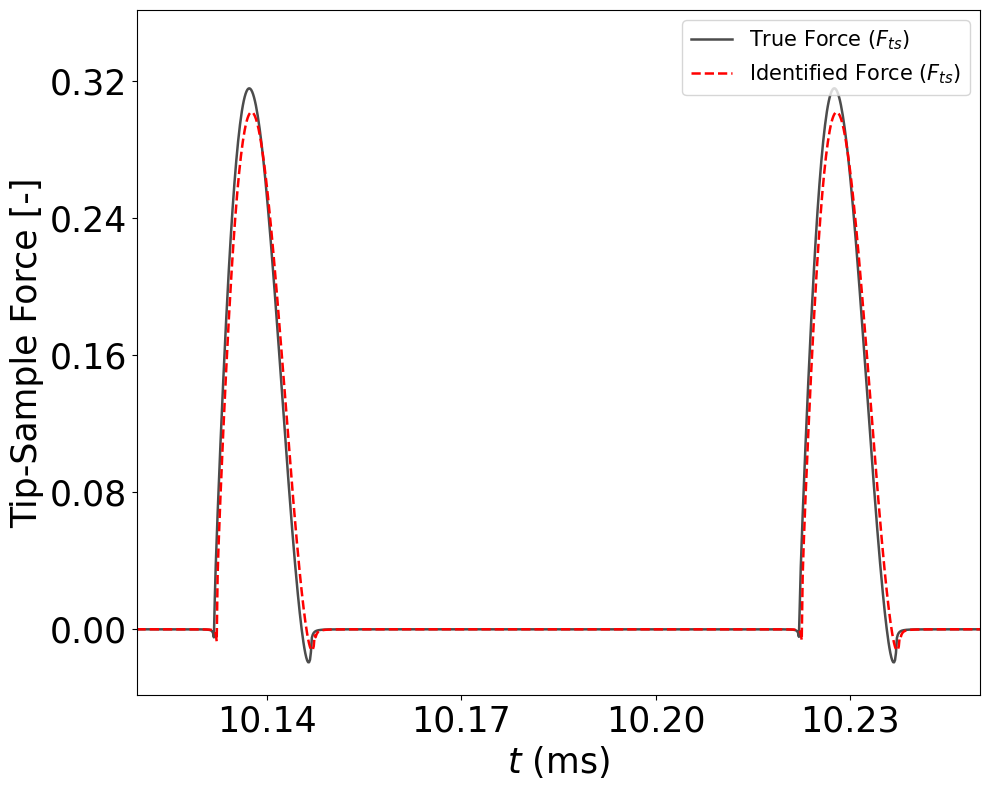

In [47]:
set_plot_style()

fig, axs = plt.subplots(1, 1, figsize=(10, 8)) 

axs.plot(time_in_ms, F_ts_true, linewidth=1.8, alpha = 0.7, label=r'True Force ($F_{ts}$)', color = 'black')
axs.plot(time_in_ms, F_ts_true_sim, linewidth=1.8, label=r'Identified Force ($F_{ts}$)', color = 'red', linestyle = '--')
axs.set_xlabel(r'$t$ (ms)', fontsize=25)
axs.set_ylabel(r'Tip-Sample Force [-]', fontsize=25)
axs.legend(loc = 'upper right', fontsize=15)

axs.set_xlim([10.12, 10.25])
axs.tick_params(axis='both', which='major', labelsize=25)
axs.xaxis.set_major_locator(MaxNLocator(nbins=5))  
axs.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout() # Adjust layout to prevent overlap
file_name = 'SINDy_viscDMT_force_prediction_steady_state_transparent'
# plt.savefig(f't_{file_name}.png', transparent=True, dpi=300, bbox_inches='tight')

### 3D Transient-State Phase Space

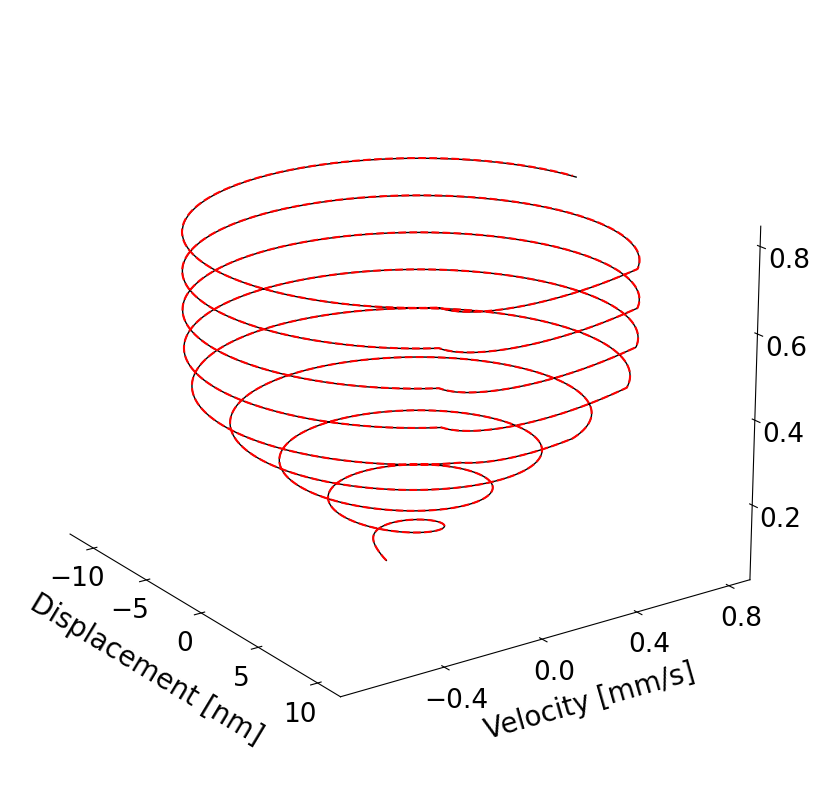

In [48]:
from matplotlib.ticker import MaxNLocator
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data filtering is already done
mask = (t_train_DMT >= 0) & (t_train_DMT <= 55)
filtered_disp = x_train_true_disp[mask]
filtered_vel = x_train_true_vel[mask]
filtered_time = true_t_train_DMT[mask]

filtered_disp_sim = x_train_true_disp_sim[mask]
filtered_vel_sim = x_train_true_vel_sim[mask]
filtered_time_sim = true_t_train_DMT[mask]

# Figure size
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

# Plotting figure
ax.plot3D(filtered_disp, filtered_vel, filtered_time*1000, color='black', label='Original Dynamics', linewidth=1.0)
ax.plot3D(filtered_disp_sim, filtered_vel_sim, filtered_time*1000, color='red', label='Identified Dynamics', linewidth=1.5, linestyle='--')
ax.set_xlabel('Displacement [nm]', fontsize=20, labelpad=15)
ax.set_ylabel('Velocity [mm/s]', fontsize=20, labelpad=15)
ax.set_zlabel('Time (ms)', fontsize=20, labelpad=15)
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
ax.zaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=19)
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')

# View Angle
ax.view_init(elev=20, azim=-35)

# Save
file_name = 'SINDy_viscDMT_3D_phase_space_transient_transparent'
# plt.savefig(f't_{file_name}.png', dpi=300, bbox_inches='tight', transparent=True, pad_inches=0.5)
plt.show()

### Transient-State Tip-Sample Force

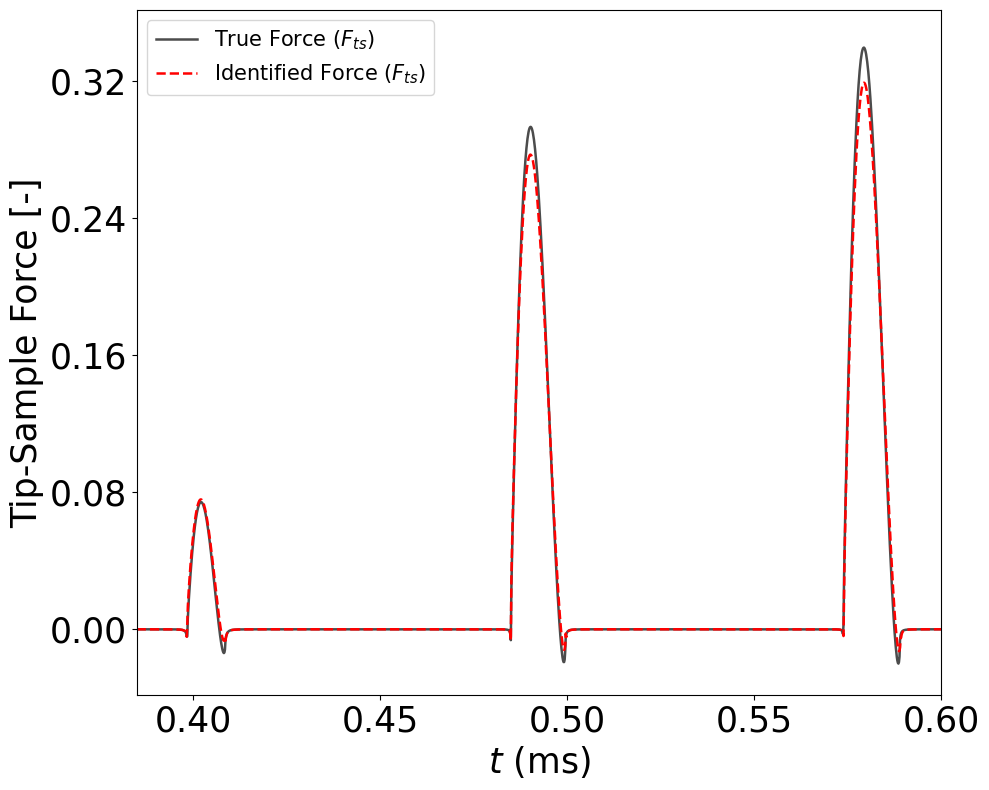

In [49]:
set_plot_style()

fig, axs = plt.subplots(1, 1, figsize=(10, 8)) 

axs.plot(time_in_ms, F_ts_true, linewidth=1.8, alpha = 0.7, label=r'True Force ($F_{ts}$)', color = 'black')
axs.plot(time_in_ms, F_ts_true_sim, linewidth=1.8, label=r'Identified Force ($F_{ts}$)', color = 'red', linestyle = '--')
axs.set_xlabel(r'$t$ (ms)', fontsize=25)
axs.set_ylabel(r'Tip-Sample Force [-]', fontsize=25)
axs.legend(loc = 'upper left', fontsize=15)
axs.set_xlim([0.385, 0.6])
axs.tick_params(axis='both', which='major', labelsize=25)
axs.xaxis.set_major_locator(MaxNLocator(nbins=5))  
axs.yaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout() # Adjust layout to prevent overlap
file_name = 'SINDy_viscDMT_force_prediction_transient_state_transparent'
# plt.savefig(f't_{file_name}.png', transparent=True, dpi=300, bbox_inches='tight')

## Accuracy calculation

In [50]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# # Displacement
evaluate_predictions(x_train_true_disp, x_train_true_disp_sim, label="Displacement")

# # Velocity
evaluate_predictions(x_train_true_vel, x_train_true_vel_sim, label="Velocity")

# Force
evaluate_predictions(F_ts_true, F_ts_true_sim, label="Force")

--- Displacement ---
MSE:    0.056238
RMSE:   0.237146
NRMSE:  1.1255%
R²:     0.998941

--- Velocity ---
MSE:    0.000299
RMSE:   0.017281
NRMSE:  1.1628%
R²:     0.998858

--- Force ---
MSE:    0.000073
RMSE:   0.008544
NRMSE:  2.3534%
R²:     0.988081



# Plot graphic representation of the Equations of motion

In [51]:
original_viscDMT_att_coef= np.array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00],
                                [   C1,              -1.00000000e+00, -d1,
                                    F_act         ,  0.00000000e+00,  C1,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00],
                                [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                                    0.00000000e+00]])

original_viscDMT_rep_coef = np.array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
                                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                                    [ (C1-(C1/(a0**2))), -1.   ,  -d2       ,  F_act     ,  0.        ,
                                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                        0.        ,  0.        ,  -C2       ,  0.        ,  0.        ,
                                        C3        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                                    [   1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                        0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [52]:
best_att_model_for_image = np.array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 9.78873784e-06, -1.00000000e+00, -1.70000000e-03,
         8.78101728e-02,  0.00000000e+00,  1.34710461e-06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

best_rep_model_for_image = np.array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
                                      0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                      0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                      0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                      0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                                    [ 0.00433328, -1.        , -2.0285    ,  0.08781017,  0.        ,
                                      0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                      0.        ,  0.        ,  -4.217108 ,  -0.6960473,  1.62890138,
                                      0.39183877,  0.        ,  0.        ,  0.        ,  0.        ,
                                      0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
                                    [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                      0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                      0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                      0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                                      0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])


## Best attractive Equation of Motion

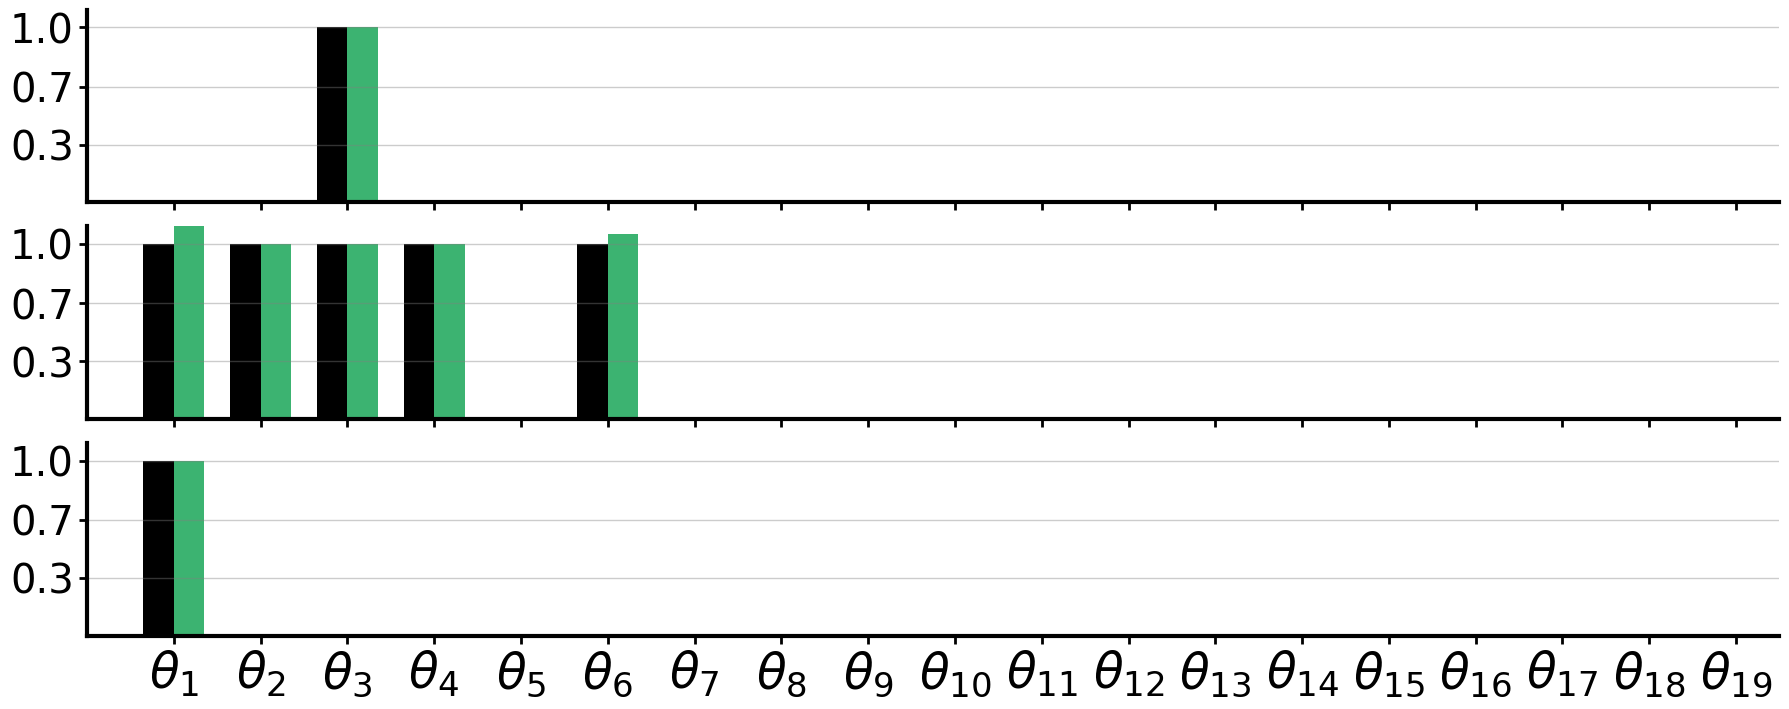

In [53]:
plot_dynamics_bars(original_viscDMT_att_coef, n_terms_correction = 15, 
                   identified_coeffs =  best_att_model_for_image,
                   plot_file_name = 'viscDMT_best_att_graphic_representation', save_plot = False)

## Best Repulsive Equation of Motion

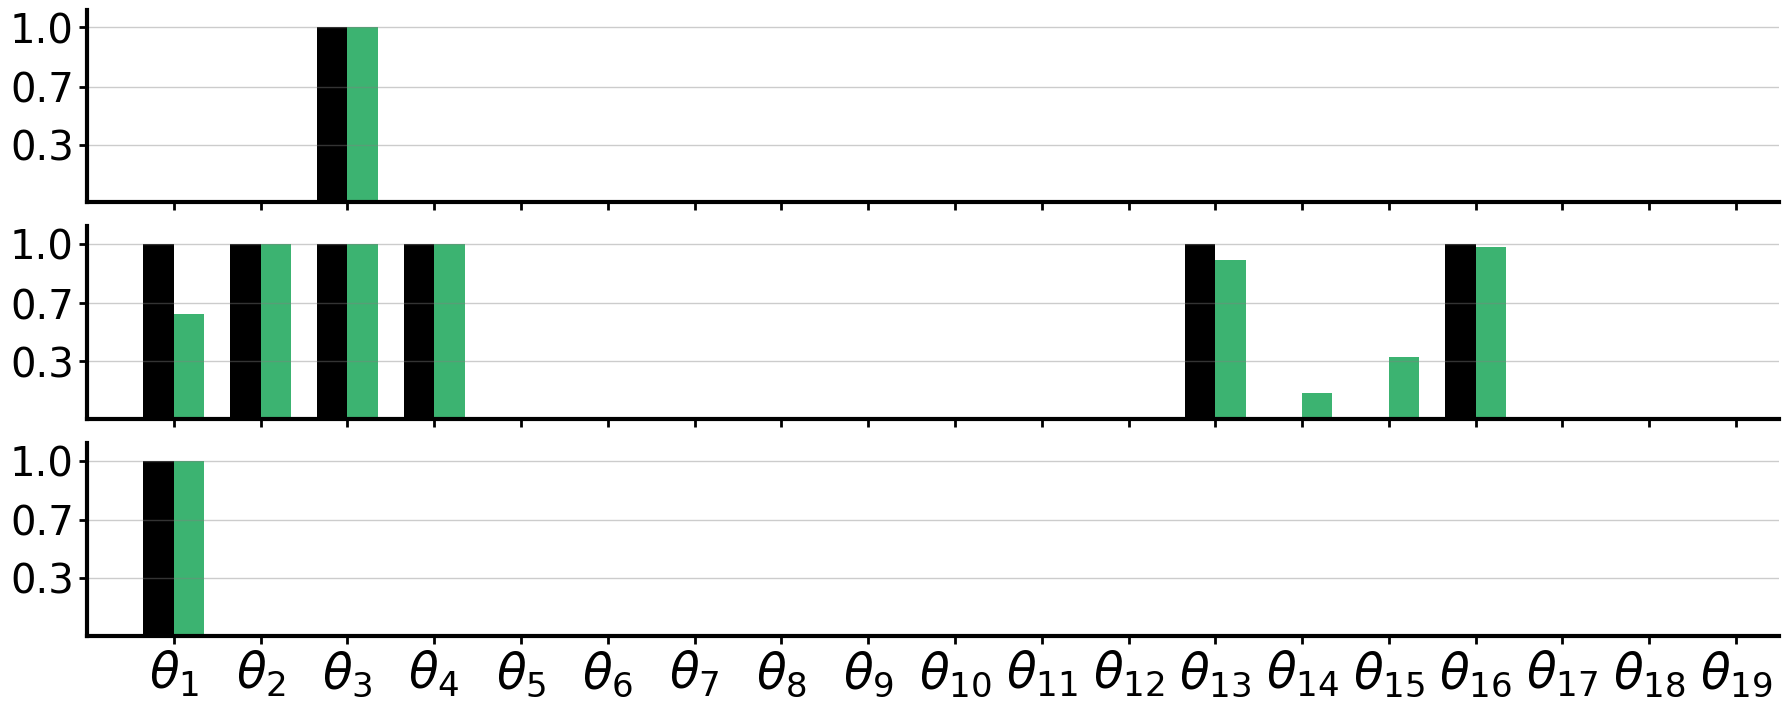

In [54]:
plot_dynamics_bars(original_viscDMT_rep_coef, n_terms_correction = 6, 
                   identified_coeffs = best_rep_model_for_image,
                   plot_file_name = 'visc_DMT_best_rep_graphic_representation', save_plot = False)